Imports

In [1]:
from catheter_utils import geometry

import glob
import os
import math
import textwrap

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

%matplotlib inline

Constants and Paths

In [2]:
# Main data paths for each catheter (manually input)
parent_path = '../data/processed/dynamic/'
catheter_paths = ['catheter231/', 'catheter299/', 'catheter306/']
main_paths = [parent_path + cath for cath in catheter_paths]

# Ground truth paths (to manually input)
GT_filename_home = [d + 'gt/home/GroundTruthCoords.csv' for d in main_paths] 
GT_filename_pos15 = [d + 'gt/p15/GroundTruthCoords.csv' for d in main_paths]
GT_filename_neg15 = [d + 'gt/n15/GroundTruthCoords.csv' for d in main_paths]
GT_filename_pos5 = [d + 'gt/p5/GroundTruthCoords.csv' for d in main_paths]
GT_filename_neg5 = [d + 'gt/n5/GroundTruthCoords.csv' for d in main_paths]

results_path = '../reports/figures/dynamic/'
# Where you would like to save the comparison plots (manually input)
comparison_plot_paths = [results_path + 'comparisonPlots/' + cath for cath in catheter_paths] #['../reports/figures/dynamic/comparisonPlots/catheter231/', '../reports/figures/dynamic/comparisonPlots/catheter299/', '../reports/figures/dynamic/comparisonPlots/catheter306/']

# Where you would like to save the box plots (manually input)
box_plot_path = results_path + 'boxPlots/'

sequences = ['HM', '3P']
cap = 'centroid_around_peak'
jpng = 'jpng'

# Recordings for each motion profile
recordings = [ [ {'{}'.format(sequences[0]): '0001',
                  '{}'.format(sequences[1]): '0001'},
                
                 {'{}'.format(sequences[0]): '0002',
                  '{}'.format(sequences[1]): '0002'} ],
                
               [ {'{}'.format(sequences[0]): '0001',
                  '{}'.format(sequences[1]): '0001'}, 
                 
                 {'{}'.format(sequences[0]): '0002',
                  '{}'.format(sequences[1]): '0002'} ],
                
               [ {'{}'.format(sequences[0]): '0001',
                  '{}'.format(sequences[1]): '0001'},
                
                 {'{}'.format(sequences[0]): '0002',
                  '{}'.format(sequences[1]): '0002'} ] ]
                 
# Function for getting ground truth coords in dataframe format
def get_gt_coords(path):

    gt_file = open(path, 'r')
    reader = gt_file.readlines()
    distal_gt = []
    proximal_gt = []

    for line in reader[1:]:
        data = line.split(',')
        if (data[-2].strip() == 'dist'):
            distal_index = int(data[-1].strip())
            distal_gt = np.array([float(data[1]), float(data[2]), float(data[3])])
            distal_df = pd.DataFrame({'Coil': distal_index, 'X Coord': distal_gt[0], 'Y Coord': distal_gt[1], 'Z Coord': distal_gt[2]}, index=[0])
            
        elif (data[-2].strip() == 'prox'):
            proximal_index = int(data[-1].strip())
            proximal_gt = np.array([float(data[1]), float(data[2]), float(data[3])])
            proximal_df = pd.DataFrame({'Coil': proximal_index, 'X Coord': proximal_gt[0], 'Y Coord': proximal_gt[1], 'Z Coord': proximal_gt[2]}, index=[0])
    
    gt_df = pd.concat([distal_df, proximal_df])
    
    return gt_df

# Get ground truth info
GT_home_coords_dfs = [get_gt_coords(GT_filename_home[0]), get_gt_coords(GT_filename_home[1]), get_gt_coords(GT_filename_home[2])]
GT_pos15_coords_dfs = [get_gt_coords(GT_filename_pos15[0]), get_gt_coords(GT_filename_pos15[1]), get_gt_coords(GT_filename_pos15[2])]
GT_neg15_coords_dfs = [get_gt_coords(GT_filename_neg15[0]), get_gt_coords(GT_filename_neg15[1]), get_gt_coords(GT_filename_neg15[2])]
GT_pos5_coords_dfs = [get_gt_coords(GT_filename_pos5[0]), get_gt_coords(GT_filename_pos5[1]), get_gt_coords(GT_filename_pos5[2])]
GT_neg5_coords_dfs = [get_gt_coords(GT_filename_neg5[0]), get_gt_coords(GT_filename_neg5[1]), get_gt_coords(GT_filename_neg5[2])]

Constant Numerical Values

In [3]:
num_caths = 3
num_profs = 4

# Coil numbers
distal_index = 6
proximal_index = 7

# Amplitudes and periods
amplitude_resp = 15 # mm
period_resp = 4024 # ms

amplitude_card = 5 # mm
period_card = 1006 # ms

# Device geometry index
geometry_index = 1 # 1 for catheter, 2 for dilator

# Start indices for each motion profile

start_idx = [ [ {'{}'.format(sequences[0]): 98,
                 '{}'.format(sequences[1]): 43}, 
                        
                {'{}'.format(sequences[0]): 63,
                 '{}'.format(sequences[1]): 48} ], 

              [ {'{}'.format(sequences[0]): 88,
                 '{}'.format(sequences[1]): 52}, 
                        
                {'{}'.format(sequences[0]): 81,
                 '{}'.format(sequences[1]): 45} ], 

              [ {'{}'.format(sequences[0]): 62,
                 '{}'.format(sequences[1]): 35}, 
                        
                {'{}'.format(sequences[0]): 60,
                 '{}'.format(sequences[1]): 31} ] ]

# Function for calculating unit vector in direction of motion (use either distal or proximal ground truth coords)
def calc_unit_vector(home, pos, neg):
    points = np.array([home, pos, neg])
    avg = np.mean(points, axis=0)
    subtracted = points - avg
    u, s, vh = np.linalg.svd(subtracted)

    return vh[0, :]

# Get ground truth distal coords
temp_dfs = [GT_home_coords_dfs[0].set_index(['Coil']), GT_home_coords_dfs[1].set_index(['Coil']), GT_home_coords_dfs[2].set_index(['Coil'])]
home_dist_coords = [np.array(temp_dfs[0].loc[distal_index]), np.array(temp_dfs[1].loc[distal_index]), np.array(temp_dfs[2].loc[distal_index])]

temp_dfs = [GT_pos15_coords_dfs[0].set_index(['Coil']), GT_pos15_coords_dfs[1].set_index(['Coil']), GT_pos15_coords_dfs[2].set_index(['Coil'])]
pos15_dist_coords = [np.array(temp_dfs[0].loc[distal_index]), np.array(temp_dfs[1].loc[distal_index]), np.array(temp_dfs[2].loc[distal_index])]

temp_dfs = [GT_neg15_coords_dfs[0].set_index(['Coil']), GT_neg15_coords_dfs[1].set_index(['Coil']), GT_neg15_coords_dfs[2].set_index(['Coil'])]
neg15_dist_coords = [np.array(temp_dfs[0].loc[distal_index]), np.array(temp_dfs[1].loc[distal_index]), np.array(temp_dfs[2].loc[distal_index])]

temp_dfs = [GT_pos5_coords_dfs[0].set_index(['Coil']), GT_pos5_coords_dfs[1].set_index(['Coil']), GT_pos5_coords_dfs[2].set_index(['Coil'])]
pos5_dist_coords = [np.array(temp_dfs[0].loc[distal_index]), np.array(temp_dfs[1].loc[distal_index]), np.array(temp_dfs[2].loc[distal_index])]

temp_dfs = [GT_neg5_coords_dfs[0].set_index(['Coil']), GT_neg5_coords_dfs[1].set_index(['Coil']), GT_neg5_coords_dfs[2].set_index(['Coil'])]
neg5_dist_coords = [np.array(temp_dfs[0].loc[distal_index]), np.array(temp_dfs[1].loc[distal_index]), np.array(temp_dfs[2].loc[distal_index])]

# Get ground truth proximal coords
temp_dfs = [GT_home_coords_dfs[0].set_index(['Coil']), GT_home_coords_dfs[1].set_index(['Coil']), GT_home_coords_dfs[2].set_index(['Coil'])]
home_prox_coords = [np.array(temp_dfs[0].loc[proximal_index]), np.array(temp_dfs[1].loc[proximal_index]), np.array(temp_dfs[2].loc[proximal_index])]

temp_dfs = [GT_pos15_coords_dfs[0].set_index(['Coil']), GT_pos15_coords_dfs[1].set_index(['Coil']), GT_pos15_coords_dfs[2].set_index(['Coil'])]
pos15_prox_coords = [np.array(temp_dfs[0].loc[proximal_index]), np.array(temp_dfs[1].loc[proximal_index]), np.array(temp_dfs[2].loc[proximal_index])]

temp_dfs = [GT_neg15_coords_dfs[0].set_index(['Coil']), GT_neg15_coords_dfs[1].set_index(['Coil']), GT_neg15_coords_dfs[2].set_index(['Coil'])]
neg15_prox_coords = [np.array(temp_dfs[0].loc[proximal_index]), np.array(temp_dfs[1].loc[proximal_index]), np.array(temp_dfs[2].loc[proximal_index])]

temp_dfs = [GT_pos5_coords_dfs[0].set_index(['Coil']), GT_pos5_coords_dfs[1].set_index(['Coil']), GT_pos5_coords_dfs[2].set_index(['Coil'])]
pos5_prox_coords = [np.array(temp_dfs[0].loc[proximal_index]), np.array(temp_dfs[1].loc[proximal_index]), np.array(temp_dfs[2].loc[proximal_index])]

temp_dfs = [GT_neg5_coords_dfs[0].set_index(['Coil']), GT_neg5_coords_dfs[1].set_index(['Coil']), GT_neg5_coords_dfs[2].set_index(['Coil'])]
neg5_prox_coords = [np.array(temp_dfs[0].loc[proximal_index]), np.array(temp_dfs[1].loc[proximal_index]), np.array(temp_dfs[2].loc[proximal_index])]

# Calculate unit vectors using distal/proximal coords
unit_vectors_from_dist_resp = np.abs([calc_unit_vector(home_dist_coords[0], pos15_dist_coords[0], neg15_dist_coords[0]), calc_unit_vector(home_dist_coords[1], pos15_dist_coords[1], neg15_dist_coords[1]), calc_unit_vector(home_dist_coords[2], pos15_dist_coords[2], neg15_dist_coords[2])])
unit_vectors_from_prox_resp = np.abs([calc_unit_vector(home_prox_coords[0], pos15_prox_coords[0], neg15_prox_coords[0]), calc_unit_vector(home_prox_coords[1], pos15_prox_coords[1], neg15_prox_coords[1]), calc_unit_vector(home_prox_coords[2], pos15_prox_coords[2], neg15_prox_coords[2])])
unit_vectors_from_dist_card = np.abs([calc_unit_vector(home_dist_coords[0], pos5_dist_coords[0], neg5_dist_coords[0]), calc_unit_vector(home_dist_coords[1], pos5_dist_coords[1], neg5_dist_coords[1]), calc_unit_vector(home_dist_coords[2], pos5_dist_coords[2], neg5_dist_coords[2])])
unit_vectors_from_prox_card = np.abs([calc_unit_vector(home_prox_coords[0], pos5_prox_coords[0], neg5_prox_coords[0]), calc_unit_vector(home_prox_coords[1], pos5_prox_coords[1], neg5_prox_coords[1]), calc_unit_vector(home_prox_coords[2], pos5_prox_coords[2], neg5_prox_coords[2])])

unit_vectors_from_dist_resp[0][0] = -1 * unit_vectors_from_dist_resp[0][0] # Need to do this for some reason

Data Processing Functions

In [4]:
def cathcoords_to_DataFrame(path, sequence, algorithm, coil, recording):
    """Convert single cathcoords.txt file to a pd.DataFrame()"""

    if path[-12:-1] == 'catheter231':
        catheter = 'Catheter 1'
    elif path[-12:-1] == 'catheter299':
        catheter = 'Catheter 2'
    elif path[-12:-1] == 'catheter306':
        catheter = 'Catheter 3'
    
    if coil == 4 or coil == 7:
        coil_name = 'Proximal Coil'
    elif coil == 5 or coil == 6:
        coil_name = 'Distal Coil'
    
    if recording == '0001':
        profile = 'Respiratory Profile (15 bpm)'
    elif recording == '0002':
        profile = 'Cardiac Profile (60 bpm)'

    fpath = glob.glob(path + 'unfiltered/{}/{}/cathcoords-coil{}-{}*txt'.format(sequence, algorithm, coil, recording))[0]
    file = open(fpath, 'r')
    lines = file.readlines()
    start_time = 0
    
    for index, line in enumerate(lines):
        line = line.split()
        for i in range(len(line)):
            line[i] = float(line[i])
        
        # setting time to start at 0
        if index == 0:
            start_time = line[4]
        line[4] = line[4] - start_time 
            
        lines[index] = line  # lines[0] = tracked x, lines[1] = tracked y, lines[2] = tracked z,
                             # lines[3] = SNR, lines[4] = timestamp, lines[5] = trig, lines[6] = resp
            
    data = np.array(lines)
    tracked_df = pd.DataFrame({'Catheter': catheter, 'Profile': profile, 'Sequence': sequence, 'Algorithm': algorithm, 'Coil': coil_name, 
                               'Time': data[:,4], 'Tracked X': data[:,0], 'Tracked Y': data[:,1], 'Tracked Z': data[:,2]})
    
    
    tracked_df.drop(tracked_df[tracked_df['Time'] > 15000].index, inplace = True) # remove all rows after 15 seconds

    return tracked_df


def get_expected_coords_card(tracked_df, start_idx, unit_vector, pos_home, amp, period):
    """From cathcoords created dataframe and defined start_index, unitVector, and speed
        determine the expected track of the catheter based on a cardiac motion profile"""
    # tracked_df: comes from cathcoords file
    # start_idx: where consistent motion starts
    # pos_home: zero position of where motion begins
    # amp: amplitude (mm)
    # period: period (ms)
    
    expected = [[], [], [], []] # [[time], [x], [y], [z]]

    prevX = pos_home[0]
    prevY = pos_home[1]
    prevZ = pos_home[2]
    y1 = 0
    
    for i in range(start_idx, len(tracked_df)):
        if i == len(tracked_df)-1:
            #print('Breaking')
            break
        else:
            x2 = tracked_df['Time'][i] - tracked_df['Time'][start_idx]
            y2 = amp * (math.sin((2 * math.pi / period) * x2))
            
            dD = (y2 - y1)
            
            expected[0].append(tracked_df['Time'][i])
            expX = prevX + dD*unit_vector[0]
            expY = prevY + dD*unit_vector[1]
            expZ = prevZ + dD*unit_vector[2]
            
            expected[1].append(expX)
            expected[2].append(expY)
            expected[3].append(expZ)
            
            prevX = expX
            prevY = expY
            prevZ = expZ
            y1 = y2
    
    expected_df = pd.DataFrame(expected)
    expected_df = expected_df.transpose()
    expected_df = expected_df.rename(columns={0:'Time', 1:'Expected X', 2:'Expected Y', 3:'Expected Z'})
    return expected_df


def get_expected_coords_resp(tracked_df, start_idx, unit_vector, pos_home, amp, period):
    """From cathcoords created dataframe and defined start_index, unitVector, and speed
        determine the expected track of the catheter based on a respiratory motion profile"""
    
    # tracked_df: comes from cathcoords file
    # start_idx: where consistent motion starts
    # pos_home: zero position of where motion begins
    # amp: amplitude (mm)
    # period: period (ms)
    
    expected = [[], [], [], []] # [[time], [x], [y], [z]]
    counter = 0

    prevX = pos_home[0]
    prevY = pos_home[1]
    prevZ = pos_home[2]
    y1 = 0
    
    for i in range(start_idx, len(tracked_df)):
        if i == len(tracked_df)-1:
            #print('Breaking')
            break
        else:
            x2 = tracked_df['Time'][i] - tracked_df['Time'][start_idx]
            # Increment counter everytime one period is completed
            if(x2 - period*counter) > period:
                counter += 1
            # Hold position at amp/2 between pi/12 and 5pi/2 in cycle
            if ((1/12)*period + counter*period) < x2 < ((5/12)*period + counter*period):
                y2 = amp/2
            else:
                y2 = amp * (math.sin((2 * math.pi/period) * x2))
            
            dD = (y2 - y1)
            
            expected[0].append(tracked_df['Time'][i])
            expX = prevX + dD*unit_vector[0]
            expY = prevY + dD*unit_vector[1]
            expZ = prevZ + dD*unit_vector[2]
            
            expected[1].append(expX)
            expected[2].append(expY)
            expected[3].append(expZ)
            
            prevX = expX
            prevY = expY
            prevZ = expZ
            y1 = y2
    
    expected_df = pd.DataFrame(expected)
    expected_df = expected_df.transpose()
    expected_df = expected_df.rename(columns={0: 'Time', 1: 'Expected X', 2: 'Expected Y', 3: 'Expected Z'})
    return expected_df


# Method for calculating tip coords
def get_tip_coords(prox_df, dist_df, geometry_index):
    """ Takes 2 dataframes and calculates tip coordinates and returns in dataframe"""
    
    if 'Tracked X' in prox_df.columns:
        time = prox_df['Time']
        x_coords, y_coords, z_coords = [], [], []
        
        for i in range(len(prox_df)):
            
            prox_coord = np.asarray([prox_df['Tracked X'][i], prox_df['Tracked Y'][i], prox_df['Tracked Z'][i]])
            dist_coord = np.asarray([dist_df['Tracked X'][i], dist_df['Tracked Y'][i], dist_df['Tracked Z'][i]])
            
            geo = geometry.GEOMETRY[geometry_index]
            fit = geo.fit_from_coils_mse(prox_coord, dist_coord)
            tip_gt = fit.tip

            x_coords.append(tip_gt[0][0])
            y_coords.append(tip_gt[0][1])
            z_coords.append(tip_gt[0][2])
            
        tip_df = pd.DataFrame({'Catheter': prox_df['Catheter'], 'Profile': prox_df['Profile'], 'Sequence': prox_df['Sequence'], 
                               'Algorithm': prox_df['Algorithm'], 'Coil': 'Tip', 'Time': time, 'Tracked X': np.asarray(x_coords),
                               'Tracked Y': np.asarray(y_coords), 'Tracked Z': np.asarray(z_coords)})
    
    elif 'Expected X' in prox_df.columns:
        time = prox_df['Time']
        x_coords, y_coords, z_coords = [], [], []
        
        for i in range(len(prox_df)):
            
            prox_coord = np.asarray([prox_df['Expected X'][i], prox_df['Expected Y'][i], prox_df['Expected Z'][i]])
            dist_coord = np.asarray([dist_df['Expected X'][i], dist_df['Expected Y'][i], dist_df['Expected Z'][i]])
            
            geo = geometry.GEOMETRY[1]
            fit = geo.fit_from_coils_mse(prox_coord, dist_coord)
            tip_gt = fit.tip

            x_coords.append(tip_gt[0][0])
            y_coords.append(tip_gt[0][1])
            z_coords.append(tip_gt[0][2])
            
        tip_df = pd.DataFrame({'Time': prox_df['Time'], 'Expected X': np.asarray(x_coords), 'Expected Y': np.asarray(y_coords), 
                            'Expected Z': np.asarray(z_coords)})
    
    return tip_df

Plotting Functions

In [5]:
def plot_tracked_vs_expected(tracked, expected, start_idx, plot_path, save=True):
    """ Plot the tracked and expected coordinates vs time"""
    # tracked: dataframe with tracked coords for all coils
    # expected: dataframe of expected motion
    # start_idx: index at which motion starts from 0 position
    # plot_path: path at which to save plots

    temp_tracked = tracked[start_idx : len(tracked)]

    catheter = tracked['Catheter'][0]
    profile = tracked['Profile'][0]
    sequence = tracked['Sequence'][0]
    coil = tracked['Coil'][0]

    sns.set_theme(style='darkgrid')

    fig, axes = plt.subplots(3, 1, sharex = True, figsize = (18, 24))
    title = '{} - Tracking {} {} using the {} Sequence'.format(profile, catheter, coil, sequence)
    min_time = np.min(temp_tracked['Time'])
    max_time = np.max(temp_tracked['Time'])
    low_time = np.round(min_time - 100)
    high_time = np.round(max_time + 100)

    # Plot X
    min = np.min(temp_tracked['Tracked X'])
    max = np.max(temp_tracked['Tracked X'])
    low = np.round(min - 5)
    high = np.round(max + 5)

    sns.lineplot(ax = axes[0], x = temp_tracked['Time'], y = temp_tracked['Tracked X'], label = 'Tracked X', linewidth = 3)
    sns.lineplot(ax = axes[0], x = expected['Time'], y = expected['Expected X'], label = 'Expected X', linewidth = 3)
    axes[0].set_ylabel('Position (mm)', fontsize = 28, fontweight = 'bold')
    axes[0].set_ylim(low, high)
    axes[0].yaxis.set_tick_params(labelsize = 24)
    axes[0].legend(loc = 'upper right', fontsize = 24)
    
    # Plot Y
    min = np.min(temp_tracked['Tracked Y'])
    max = np.max(temp_tracked['Tracked Y'])
    low = np.round(min - 5)
    high = np.round(max + 5)

    sns.lineplot(ax = axes[1], x = temp_tracked['Time'], y = temp_tracked['Tracked Y'], label = 'Tracked Y', linewidth = 3)
    sns.lineplot(ax = axes[1], x = expected['Time'], y = expected['Expected Y'], label = 'Expected Y', linewidth = 3)
    axes[1].set_ylabel('Position (mm)', fontsize = 28, fontweight = 'bold')
    axes[1].set_ylim(low, high)
    axes[1].yaxis.set_tick_params(labelsize = 24)
    axes[1].legend(loc = 'upper right', fontsize = 24)

    # Plot Z
    min = np.min(temp_tracked['Tracked Z'])
    max = np.max(temp_tracked['Tracked Z'])
    low = np.round(min - 5)
    high = np.round(max + 5)
    
    sns.lineplot(ax = axes[2], x = temp_tracked['Time'], y = temp_tracked['Tracked Z'], label = 'Tracked Z', linewidth = 3)
    sns.lineplot(ax = axes[2], x = expected['Time'], y = expected['Expected Z'], label = 'Expected Z', linewidth = 3)
    axes[2].set_xlabel('Time (ms)', fontsize = 28, fontweight = 'bold')
    axes[2].set_ylabel('Position (mm)', fontsize = 28, fontweight = 'bold')
    axes[2].set_xlim(low_time, high_time)
    axes[2].set_ylim(low, high)
    axes[2].xaxis.set_tick_params(labelsize = 24)
    axes[2].yaxis.set_tick_params(labelsize = 24)
    axes[2].legend(loc = 'upper right', fontsize = 24)
    
    plt.tight_layout()

    # if save == True:
    #     if not os.path.isdir(plot_path + '{}/{}/{}'.format(profile, sequence, coil)):
    #         os.makedirs(plot_path + '{}/{}/{}'.format(profile, sequence, coil))
        
    #     fig.savefig(plot_path + '{}/{}/{}/all.png'.format(profile, sequence, coil), dpi=600)
    
    plt.show()

    return


def plot_motion_error(tracked, expected, start_idx, plot_path, save=True):
    """ Plot the tracked and expected coordinates vs time"""
    # tracked: dataframe with tracked coords for all coils
    # expected: dataframe of expected motion
    # start_idx: index at which motion starts from 0 position
    # plot_path: path at which to save plots

    catheter = tracked['Catheter'][0]
    profile = tracked['Profile'][0]
    sequence = tracked['Sequence'][0]
    coil = tracked['Coil'][0]

    # Only get values for times of expected motion
    tracked_error = (tracked[start_idx : start_idx + len(expected)]).copy()
    tracked_error.reset_index(drop=True, inplace=True)
    
    tracked_error['Error in X'] = abs(tracked_error['Tracked X'] - expected['Expected X'])
    tracked_error['Error in Y'] = abs(tracked_error['Tracked Y'] - expected['Expected Y'])
    tracked_error['Error in Z'] = abs(tracked_error['Tracked Z'] - expected['Expected Z'])

    total_error = ((tracked_error['Error in X'])**2 + (tracked_error['Error in Y'])**2 + (tracked_error['Error in Z'])**2)**0.5
    tracked_error['Total Error'] = total_error

    sns.set_style("whitegrid", {'grid.color': '0.8', 'axes.edgecolor': 'black', 'axes.spines.right': False, 'axes.spines.top': False, 'xtick.bottom': True, 'ytick.left': True})
    fig1, axes = plt.subplots(3, 1, sharex = True, figsize = (18, 24))
    title = '{} - Tracking {} {} using the {} Sequence'.format(profile, catheter, coil, sequence)
    min_time = np.min(tracked_error['Time'])
    max_time = np.max(tracked_error['Time'])
    low_time = np.round(min_time - 100)
    high_time = np.round(max_time + 100)
    low = 0
    high = 12

    mean_x = np.round(np.mean(tracked_error['Error in X']), 1)
    mean_y = np.round(np.mean(tracked_error['Error in Y']), 1)
    mean_z = np.round(np.mean(tracked_error['Error in Z']), 1)

    # Plot X, Y, Z error
    
    # X error
    sns.lineplot(ax = axes[0], x = tracked_error['Time'], y = tracked_error['Error in X'], label = 'X Error', linewidth = 2)
    axes[0].axhline(y = mean_x, color = 'g', linestyle = '--', label = 'Mean X Error = {}mm'.format(mean_x), linewidth = 2)
    axes[0].set_ylabel('Error (mm)', fontsize = 48)
    axes[0].set_ylim(low, high)
    axes[0].minorticks_on()
    axes[0].xaxis.set_tick_params(which = 'major', labelsize = 36, color = 'grey')
    axes[0].yaxis.set_tick_params(which = 'major', labelsize = 36, color = 'grey')
    axes[0].xaxis.set_tick_params(which = 'minor', direction = 'in', labelsize = 32, color = 'grey')
    axes[0].yaxis.set_tick_params(which = 'minor', direction = 'in', labelsize = 32, color = 'grey')
    axes[0].legend(loc = 'upper right', fontsize = 32)

    # Y Error
    sns.lineplot(ax = axes[1], x = tracked_error['Time'], y = tracked_error['Error in Y'], label = 'Y Error', linewidth = 2)
    axes[1].axhline(y = mean_y, color = 'g', linestyle = '--', label = 'Mean Y Error = {}mm'.format(mean_y), linewidth = 2)
    axes[1].set_ylabel('Error (mm)', fontsize = 48)
    axes[1].set_ylim(low, high)
    axes[1].minorticks_on()
    axes[1].xaxis.set_tick_params(which = 'major', labelsize = 36, color = 'grey')
    axes[1].yaxis.set_tick_params(which = 'major', labelsize = 36, color = 'grey')
    axes[1].xaxis.set_tick_params(which = 'minor', direction = 'in', labelsize = 32, color = 'grey')
    axes[1].yaxis.set_tick_params(which = 'minor', direction = 'in', labelsize = 32, color = 'grey')
    axes[1].legend(loc = 'upper right', fontsize = 32)

    # Z Error
    sns.lineplot(ax = axes[2], x = tracked_error['Time'], y = tracked_error['Error in Z'], label = 'Z Error', linewidth = 2)
    axes[2].axhline(y = mean_z, color = 'g', linestyle = '--', label = 'Mean Z Error = {}mm'.format(mean_z), linewidth = 2)
    axes[2].set_xlabel('Time (ms)', fontsize = 48)
    axes[2].set_ylabel('Error (mm)', fontsize = 48)
    axes[2].set_xlim(low_time, high_time)
    axes[2].set_ylim(low, high)
    axes[2].minorticks_on()
    axes[2].xaxis.set_tick_params(which = 'major', labelsize = 36, color = 'grey')
    axes[2].yaxis.set_tick_params(which = 'major', labelsize = 36, color = 'grey')
    axes[2].xaxis.set_tick_params(which = 'minor', direction = 'in', labelsize = 32, color = 'grey')
    axes[2].yaxis.set_tick_params(which = 'minor', direction = 'in', labelsize = 32, color = 'grey')
    axes[2].legend(loc = 'upper right', fontsize = 32)

    # if save == True:
    #     if not os.path.isdir(plot_path + '{}/{}/{}'.format(profile, sequence, coil)):
    #         os.makedirs(plot_path + '{}/{}/{}'.format(profile, sequence, coil))
        
    #     fig1.savefig(plot_path + '{}/{}/{}/motion_error_xyz.pdf'.format(profile, sequence, coil), dpi=600)

    plt.show()

    return


def merge_plot_dfs(plot_dfs):
    
    plot_df = pd.DataFrame(columns=['Catheter', 'Sequence', 'Algorithm', 'Coil', 'Error in X', 'Error in Y', 'Error in Z', 'Total Error'])

    for df in plot_dfs:
        plot_df = plot_df.append(df, sort=True)
    
    plot_df.reset_index(drop=True, inplace=True)

    return plot_df


def calculate_error(tracked_dataframes, expected_dataframes, start_idx):
    """Calculate the difference in each of X, Y, Z coords then calc total error
        and save into and return all data in single pandas dataframe"""
    plot_df = pd.DataFrame(columns=['Catheter', 'Sequence', 'Algorithm', 'Coil', 'Error in X', 'Error in Y', 'Error in Z', 'Total Error'])

    for tracked in tracked_dataframes:

        # Determine if proximal coil, distal coil, or tip
        if tracked['Coil'][0] == 'Proximal Coil':
            expected = expected_dataframes[0]
        elif tracked['Coil'][0] == 'Distal Coil':
            expected = expected_dataframes[1]
        elif tracked['Coil'][0] == 'Tip':
            expected = expected_dataframes[2]
        
        # Only get values for times of expected motion
        temp_tracked = (tracked[start_idx : start_idx + len(expected)]).copy()
        temp_tracked.reset_index(drop=True, inplace=True)
        
        temp_tracked['Error in X'] = abs(temp_tracked['Tracked X'] - expected['Expected X'])
        temp_tracked['Error in Y'] = abs(temp_tracked['Tracked Y'] - expected['Expected Y'])
        temp_tracked['Error in Z'] = abs(temp_tracked['Tracked Z'] - expected['Expected Z'])
    
        total_error = ((temp_tracked['Error in X'])**2 + (temp_tracked['Error in Y'])**2 + (temp_tracked['Error in Z'])**2)**0.5
        temp_tracked['Total Error'] = total_error

        plot_df = plot_df.append(temp_tracked, sort=True)

    plot_df = plot_df[plot_df.Coil != 'Proximal Coil']
    plot_df = plot_df[plot_df.Coil != 'Distal Coil']

    plot_df.reset_index(drop=True, inplace=True)

    return plot_df

# Method for showing statistical significance on error box plots
def pval_to_stars(pval):
    if pval < 0.001:
        return '***'
    elif pval < 0.01:
        return '**'
    elif pval < 0.05:
        return '*'
    else:
        return ''

def plot_error_box_plot(plot_df, plot_path, save=True):
    """Plots boxplot with plot_df being the dataframe with the sequence, coil, and total error info"""
    
    catheter = plot_df['Catheter'][0]
    profile = plot_df['Profile'][0]
    sequence = plot_df['Sequence'][0]
    algorithm = plot_df['Algorithm'][0]

    plot_df['Sequence'] = pd.Categorical(plot_df['Sequence'], categories=[sequences[1], sequences[0]], ordered=True)
    # plot_df['Algorithm'] = pd.Categorical(plot_df['Algorithm'], categories=['jpng', 'centroid_around_peak'], ordered=True)

    sns.set_style("whitegrid", {'grid.color': '0.8', 'axes.edgecolor': 'black', 'axes.spines.right': False, 'axes.spines.top': False, 'xtick.bottom': True, 'ytick.left': True})
    
    fig = plt.figure(figsize = (9, 8))

    ### Uncomment the next 3 lines if you want to generate tip tracking boxplots separated by sequences only, otherwise leave them commented ###
    ax1 = sns.boxplot(x = plot_df['Sequence'], y = plot_df['Total Error'], orient = 'v', width = 0.4, showfliers = False, linewidth = 2, palette = "Set2")
    plt.ylabel('Total Tip Error (mm)', fontsize = 36)
    # plt.ylabel('Total Tip Error (mm)', fontsize = 20, fontweight = 'bold')
    plt.ylim(0, 13)

    # For p-value plotting
    total_error_3P = plot_df.query("Sequence=='"+sequences[1]+"'")['Total Error']
    total_error_HM = plot_df.query("Sequence=='"+sequences[0]+"'")['Total Error']
    
    t, p_r = stats.ttest_ind(total_error_3P, total_error_HM)

    # Calculate the maximum whisker height for 3P
    Q1 = np.percentile(total_error_3P, 25)
    Q3 = np.percentile(total_error_3P, 75)
    IQR = Q3 - Q1
    max_whisker_height_3P = Q3 + 1.5 * IQR

    # Calculate the maximum whisker height for HM
    Q1 = np.percentile(total_error_HM, 25)
    Q3 = np.percentile(total_error_HM, 75)
    IQR = Q3 - Q1
    max_whisker_height_HM = Q3 + 1.5 * IQR

    stars = pval_to_stars(p_r)
    
    if stars:
        x1, x2 = 0, 1
        y, h, col = max_whisker_height_3P + 0.5, 0.25, 'k'
        ymax = np.max([np.max(max_whisker_height_HM), np.max(max_whisker_height_3P)])
        y = ymax + 0.5
        ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        ax1.text((x1+x2)*.5, y+h, stars, ha='center',
                 va='bottom', color=col, fontsize=32)

    plt.xlabel('Sequence', fontsize = 36)
    plt.minorticks_on()
    plt.tick_params(which = 'minor', bottom=False)
    plt.tick_params(which = 'minor', direction = 'in', color = 'grey')
    plt.xticks(fontsize = 32)
    plt.yticks(fontsize = 32)
    plt.axhline(y = 5, color = 'r', linestyle = '--', linewidth = 2, label = '5mm Error Constraint')
    plt.legend(loc = 'upper right', fontsize = 24)
    plt.tight_layout()
    
    # if save == True:
    #     if not os.path.isdir(plot_path + '{}'.format(profile)):
    #         os.makedirs(plot_path + '{}'.format(profile))
        
    #     fig.savefig(plot_path + '{}/box_error_tip.pdf'.format(profile), dpi=600)

    plt.show()
    
    return 

Dataframes for Coil Tracking Data

In [6]:
# Convert coil cathcoords to dataframes

# Sequence 1: Hadamard Multiplexed - JPNG
FH512_2_jpng_6_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[0], jpng, distal_index,   recordings[0][0][sequences[0]])
FH512_2_jpng_7_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[0], jpng, proximal_index, recordings[0][0][sequences[0]])
FH512_2_jpng_6_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[0], jpng, distal_index,   recordings[0][1][sequences[0]])
FH512_2_jpng_7_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[0], jpng, proximal_index, recordings[0][1][sequences[0]])

FH512_2_jpng_6_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[0], jpng, distal_index,   recordings[1][0][sequences[0]])
FH512_2_jpng_7_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[0], jpng, proximal_index, recordings[1][0][sequences[0]])
FH512_2_jpng_6_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[0], jpng, distal_index,   recordings[1][1][sequences[0]])
FH512_2_jpng_7_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[0], jpng, proximal_index, recordings[1][1][sequences[0]])

FH512_2_jpng_6_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[0], jpng, distal_index,   recordings[2][0][sequences[0]])
FH512_2_jpng_7_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[0], jpng, proximal_index, recordings[2][0][sequences[0]])
FH512_2_jpng_6_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[0], jpng, distal_index,   recordings[2][1][sequences[0]])
FH512_2_jpng_7_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[0], jpng, proximal_index, recordings[2][1][sequences[0]])

# Sequence 1: Hadamard Multiplexed - CAP
FH512_2_cap_6_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[0], cap, distal_index,   recordings[0][0][sequences[0]])
FH512_2_cap_7_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[0], cap, proximal_index, recordings[0][0][sequences[0]])
FH512_2_cap_6_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[0], cap, distal_index,   recordings[0][1][sequences[0]])
FH512_2_cap_7_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[0], cap, proximal_index, recordings[0][1][sequences[0]])

FH512_2_cap_6_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[0], cap, distal_index,   recordings[1][0][sequences[0]])
FH512_2_cap_7_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[0], cap, proximal_index, recordings[1][0][sequences[0]])
FH512_2_cap_6_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[0], cap, distal_index,   recordings[1][1][sequences[0]])
FH512_2_cap_7_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[0], cap, proximal_index, recordings[1][1][sequences[0]])

FH512_2_cap_6_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[0], cap, distal_index,   recordings[2][0][sequences[0]])
FH512_2_cap_7_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[0], cap, proximal_index, recordings[2][0][sequences[0]])
FH512_2_cap_6_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[0], cap, distal_index,   recordings[2][1][sequences[0]])
FH512_2_cap_7_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[0], cap, proximal_index, recordings[2][1][sequences[0]])

# Sequence 2: Conventional - JPNG
SRI_2_jpng_6_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[1], jpng, distal_index,   recordings[0][0][sequences[1]])
SRI_2_jpng_7_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[1], jpng, proximal_index, recordings[0][0][sequences[1]])
SRI_2_jpng_6_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[1], jpng, distal_index,   recordings[0][1][sequences[1]])
SRI_2_jpng_7_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[1], jpng, proximal_index, recordings[0][1][sequences[1]])

SRI_2_jpng_6_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[1], jpng, distal_index,   recordings[1][0][sequences[1]])
SRI_2_jpng_7_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[1], jpng, proximal_index, recordings[1][0][sequences[1]])
SRI_2_jpng_6_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[1], jpng, distal_index,   recordings[1][1][sequences[1]])
SRI_2_jpng_7_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[1], jpng, proximal_index, recordings[1][1][sequences[1]])

SRI_2_jpng_6_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[1], jpng, distal_index,   recordings[2][0][sequences[1]])
SRI_2_jpng_7_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[1], jpng, proximal_index, recordings[2][0][sequences[1]])
SRI_2_jpng_6_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[1], jpng, distal_index,   recordings[2][1][sequences[1]])
SRI_2_jpng_7_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[1], jpng, proximal_index, recordings[2][1][sequences[1]])

# Sequence 2: Conventional - CAP
SRI_2_cap_6_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[1], cap, distal_index,   recordings[0][0][sequences[1]])
SRI_2_cap_7_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[1], cap, proximal_index, recordings[0][0][sequences[1]])
SRI_2_cap_6_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[1], cap, distal_index,   recordings[0][1][sequences[1]])
SRI_2_cap_7_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[1], cap, proximal_index, recordings[0][1][sequences[1]])

SRI_2_cap_6_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[1], cap, distal_index,   recordings[1][0][sequences[1]])
SRI_2_cap_7_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[1], cap, proximal_index, recordings[1][0][sequences[1]])
SRI_2_cap_6_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[1], cap, distal_index,   recordings[1][1][sequences[1]])
SRI_2_cap_7_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[1], cap, proximal_index, recordings[1][1][sequences[1]])

SRI_2_cap_6_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[1], cap, distal_index,   recordings[2][0][sequences[1]])
SRI_2_cap_7_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[1], cap, proximal_index, recordings[2][0][sequences[1]])
SRI_2_cap_6_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[1], cap, distal_index,   recordings[2][1][sequences[1]])
SRI_2_cap_7_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[1], cap, proximal_index, recordings[2][1][sequences[1]])

Dataframes for Tip Tracking Data

In [7]:
# Get tip coords from tracked data

# Sequence 1: Hadamard Multiplexed - JPNG
FH512_2_jpng_tip_231_resp = get_tip_coords(FH512_2_jpng_7_231_resp, FH512_2_jpng_6_231_resp, geometry_index)
FH512_2_jpng_tip_231_card = get_tip_coords(FH512_2_jpng_7_231_card, FH512_2_jpng_6_231_card, geometry_index)

FH512_2_jpng_tip_299_resp = get_tip_coords(FH512_2_jpng_7_299_resp, FH512_2_jpng_6_299_resp, geometry_index)
FH512_2_jpng_tip_299_card = get_tip_coords(FH512_2_jpng_7_299_card, FH512_2_jpng_6_299_card, geometry_index)

FH512_2_jpng_tip_306_resp = get_tip_coords(FH512_2_jpng_7_306_resp, FH512_2_jpng_6_306_resp, geometry_index)
FH512_2_jpng_tip_306_card = get_tip_coords(FH512_2_jpng_7_306_card, FH512_2_jpng_6_306_card, geometry_index)

# Sequence 1: Hadamard Multiplexed - CAP
FH512_2_cap_tip_231_resp = get_tip_coords(FH512_2_cap_7_231_resp, FH512_2_cap_6_231_resp, geometry_index)
FH512_2_cap_tip_231_card = get_tip_coords(FH512_2_cap_7_231_card, FH512_2_cap_6_231_card, geometry_index)

FH512_2_cap_tip_299_resp = get_tip_coords(FH512_2_cap_7_299_resp, FH512_2_cap_6_299_resp, geometry_index)
FH512_2_cap_tip_299_card = get_tip_coords(FH512_2_cap_7_299_card, FH512_2_cap_6_299_card, geometry_index)

FH512_2_cap_tip_306_resp = get_tip_coords(FH512_2_cap_7_306_resp, FH512_2_cap_6_306_resp, geometry_index)
FH512_2_cap_tip_306_card = get_tip_coords(FH512_2_cap_7_306_card, FH512_2_cap_6_306_card, geometry_index)

# Sequence 2: Conventional - JPNG
SRI_2_jpng_tip_231_resp = get_tip_coords(SRI_2_jpng_7_231_resp, SRI_2_jpng_6_231_resp, geometry_index)
SRI_2_jpng_tip_231_card = get_tip_coords(SRI_2_jpng_7_231_card, SRI_2_jpng_6_231_card, geometry_index)

SRI_2_jpng_tip_299_resp = get_tip_coords(SRI_2_jpng_7_299_resp, SRI_2_jpng_6_299_resp, geometry_index)
SRI_2_jpng_tip_299_card = get_tip_coords(SRI_2_jpng_7_299_card, SRI_2_jpng_6_299_card, geometry_index)

SRI_2_jpng_tip_306_resp = get_tip_coords(SRI_2_jpng_7_306_resp, SRI_2_jpng_6_306_resp, geometry_index)
SRI_2_jpng_tip_306_card = get_tip_coords(SRI_2_jpng_7_306_card, SRI_2_jpng_6_306_card, geometry_index)

# Sequence 2: Conventional - CAP
SRI_2_cap_tip_231_resp = get_tip_coords(SRI_2_cap_7_231_resp, SRI_2_cap_6_231_resp, geometry_index)
SRI_2_cap_tip_231_card = get_tip_coords(SRI_2_cap_7_231_card, SRI_2_cap_6_231_card, geometry_index)

SRI_2_cap_tip_299_resp = get_tip_coords(SRI_2_cap_7_299_resp, SRI_2_cap_6_299_resp, geometry_index)
SRI_2_cap_tip_299_card = get_tip_coords(SRI_2_cap_7_299_card, SRI_2_cap_6_299_card, geometry_index)

SRI_2_cap_tip_306_resp = get_tip_coords(SRI_2_cap_7_306_resp, SRI_2_cap_6_306_resp, geometry_index)
SRI_2_cap_tip_306_card = get_tip_coords(SRI_2_cap_7_306_card, SRI_2_cap_6_306_card, geometry_index)


Dataframes for Ground Truth (Expected) Coil Data

In [8]:
# Get expected coil coords for each sequence

# Sequence 1: Hadamard Multiplexed - JPNG
FH512_2_jpng_6_expected_231_resp = get_expected_coords_resp(FH512_2_jpng_6_231_resp, start_idx[0][0][sequences[0]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_resp, period_resp)
FH512_2_jpng_7_expected_231_resp = get_expected_coords_resp(FH512_2_jpng_7_231_resp, start_idx[0][0][sequences[0]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_resp, period_resp)
FH512_2_jpng_6_expected_231_card = get_expected_coords_card(FH512_2_jpng_6_231_card, start_idx[0][1][sequences[0]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_card, period_card)
FH512_2_jpng_7_expected_231_card = get_expected_coords_card(FH512_2_jpng_7_231_card, start_idx[0][1][sequences[0]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_card, period_card)

FH512_2_jpng_6_expected_299_resp = get_expected_coords_resp(FH512_2_jpng_6_299_resp, start_idx[1][0][sequences[0]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_resp, period_resp)
FH512_2_jpng_7_expected_299_resp = get_expected_coords_resp(FH512_2_jpng_7_299_resp, start_idx[1][0][sequences[0]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_resp, period_resp)
FH512_2_jpng_6_expected_299_card = get_expected_coords_card(FH512_2_jpng_6_299_card, start_idx[1][1][sequences[0]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_card, period_card)
FH512_2_jpng_7_expected_299_card = get_expected_coords_card(FH512_2_jpng_7_299_card, start_idx[1][1][sequences[0]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_card, period_card)

FH512_2_jpng_6_expected_306_resp = get_expected_coords_resp(FH512_2_jpng_6_306_resp, start_idx[2][0][sequences[0]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_resp, period_resp)
FH512_2_jpng_7_expected_306_resp = get_expected_coords_resp(FH512_2_jpng_7_306_resp, start_idx[2][0][sequences[0]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_resp, period_resp)
FH512_2_jpng_6_expected_306_card = get_expected_coords_card(FH512_2_jpng_6_306_card, start_idx[2][1][sequences[0]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_card, period_card)
FH512_2_jpng_7_expected_306_card = get_expected_coords_card(FH512_2_jpng_7_306_card, start_idx[2][1][sequences[0]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_card, period_card)

# Sequence 1: Hadamard Multiplexed - CAP
FH512_2_cap_6_expected_231_resp = get_expected_coords_resp(FH512_2_cap_6_231_resp, start_idx[0][0][sequences[0]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_resp, period_resp)
FH512_2_cap_7_expected_231_resp = get_expected_coords_resp(FH512_2_cap_7_231_resp, start_idx[0][0][sequences[0]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_resp, period_resp)
FH512_2_cap_6_expected_231_card = get_expected_coords_card(FH512_2_cap_6_231_card, start_idx[0][1][sequences[0]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_card, period_card)
FH512_2_cap_7_expected_231_card = get_expected_coords_card(FH512_2_cap_7_231_card, start_idx[0][1][sequences[0]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_card, period_card)

FH512_2_cap_6_expected_299_resp = get_expected_coords_resp(FH512_2_cap_6_299_resp, start_idx[1][0][sequences[0]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_resp, period_resp)
FH512_2_cap_7_expected_299_resp = get_expected_coords_resp(FH512_2_cap_7_299_resp, start_idx[1][0][sequences[0]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_resp, period_resp)
FH512_2_cap_6_expected_299_card = get_expected_coords_card(FH512_2_cap_6_299_card, start_idx[1][1][sequences[0]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_card, period_card)
FH512_2_cap_7_expected_299_card = get_expected_coords_card(FH512_2_cap_7_299_card, start_idx[1][1][sequences[0]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_card, period_card)

FH512_2_cap_6_expected_306_resp = get_expected_coords_resp(FH512_2_cap_6_306_resp, start_idx[2][0][sequences[0]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_resp, period_resp)
FH512_2_cap_7_expected_306_resp = get_expected_coords_resp(FH512_2_cap_7_306_resp, start_idx[2][0][sequences[0]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_resp, period_resp)
FH512_2_cap_6_expected_306_card = get_expected_coords_card(FH512_2_cap_6_306_card, start_idx[2][1][sequences[0]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_card, period_card)
FH512_2_cap_7_expected_306_card = get_expected_coords_card(FH512_2_cap_7_306_card, start_idx[2][1][sequences[0]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_card, period_card)

# Sequence 2: Conventional - JPNG
SRI_2_jpng_6_expected_231_resp = get_expected_coords_resp(SRI_2_jpng_6_231_resp, start_idx[0][0][sequences[1]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_resp, period_resp)
SRI_2_jpng_7_expected_231_resp = get_expected_coords_resp(SRI_2_jpng_7_231_resp, start_idx[0][0][sequences[1]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_resp, period_resp)
SRI_2_jpng_6_expected_231_card = get_expected_coords_card(SRI_2_jpng_6_231_card, start_idx[0][1][sequences[1]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_card, period_card)
SRI_2_jpng_7_expected_231_card = get_expected_coords_card(SRI_2_jpng_7_231_card, start_idx[0][1][sequences[1]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_card, period_card)

SRI_2_jpng_6_expected_299_resp = get_expected_coords_resp(SRI_2_jpng_6_299_resp, start_idx[1][0][sequences[1]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_resp, period_resp)
SRI_2_jpng_7_expected_299_resp = get_expected_coords_resp(SRI_2_jpng_7_299_resp, start_idx[1][0][sequences[1]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_resp, period_resp)
SRI_2_jpng_6_expected_299_card = get_expected_coords_card(SRI_2_jpng_6_299_card, start_idx[1][1][sequences[1]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_card, period_card)
SRI_2_jpng_7_expected_299_card = get_expected_coords_card(SRI_2_jpng_7_299_card, start_idx[1][1][sequences[1]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_card, period_card)

SRI_2_jpng_6_expected_306_resp = get_expected_coords_resp(SRI_2_jpng_6_306_resp, start_idx[2][0][sequences[1]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_resp, period_resp)
SRI_2_jpng_7_expected_306_resp = get_expected_coords_resp(SRI_2_jpng_7_306_resp, start_idx[2][0][sequences[1]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_resp, period_resp)
SRI_2_jpng_6_expected_306_card = get_expected_coords_card(SRI_2_jpng_6_306_card, start_idx[2][1][sequences[1]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_card, period_card)
SRI_2_jpng_7_expected_306_card = get_expected_coords_card(SRI_2_jpng_7_306_card, start_idx[2][1][sequences[1]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_card, period_card)

# Sequence 2: Conventional - CAP
SRI_2_cap_6_expected_231_resp = get_expected_coords_resp(SRI_2_cap_6_231_resp, start_idx[0][0][sequences[1]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_resp, period_resp)
SRI_2_cap_7_expected_231_resp = get_expected_coords_resp(SRI_2_cap_7_231_resp, start_idx[0][0][sequences[1]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_resp, period_resp)
SRI_2_cap_6_expected_231_card = get_expected_coords_card(SRI_2_cap_6_231_card, start_idx[0][1][sequences[1]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_card, period_card)
SRI_2_cap_7_expected_231_card = get_expected_coords_card(SRI_2_cap_7_231_card, start_idx[0][1][sequences[1]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_card, period_card)

SRI_2_cap_6_expected_299_resp = get_expected_coords_resp(SRI_2_cap_6_299_resp, start_idx[1][0][sequences[1]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_resp, period_resp)
SRI_2_cap_7_expected_299_resp = get_expected_coords_resp(SRI_2_cap_7_299_resp, start_idx[1][0][sequences[1]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_resp, period_resp)
SRI_2_cap_6_expected_299_card = get_expected_coords_card(SRI_2_cap_6_299_card, start_idx[1][1][sequences[1]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_card, period_card)
SRI_2_cap_7_expected_299_card = get_expected_coords_card(SRI_2_cap_7_299_card, start_idx[1][1][sequences[1]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_card, period_card)

SRI_2_cap_6_expected_306_resp = get_expected_coords_resp(SRI_2_cap_6_306_resp, start_idx[2][0][sequences[1]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_resp, period_resp)
SRI_2_cap_7_expected_306_resp = get_expected_coords_resp(SRI_2_cap_7_306_resp, start_idx[2][0][sequences[1]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_resp, period_resp)
SRI_2_cap_6_expected_306_card = get_expected_coords_card(SRI_2_cap_6_306_card, start_idx[2][1][sequences[1]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_card, period_card)
SRI_2_cap_7_expected_306_card = get_expected_coords_card(SRI_2_cap_7_306_card, start_idx[2][1][sequences[1]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_card, period_card)


Dataframes for GT (Expected) Tip Data

In [9]:
# Get GT expected tip coords for each sequence

# Sequence 1: Hadamard Multiplexed - JPNG
FH512_2_jpng_tip_expected_231_resp = get_tip_coords(FH512_2_jpng_7_expected_231_resp, FH512_2_jpng_6_expected_231_resp, geometry_index)
FH512_2_jpng_tip_expected_231_card = get_tip_coords(FH512_2_jpng_7_expected_231_card, FH512_2_jpng_6_expected_231_card, geometry_index)

FH512_2_jpng_tip_expected_299_resp = get_tip_coords(FH512_2_jpng_7_expected_299_resp, FH512_2_jpng_6_expected_299_resp, geometry_index)
FH512_2_jpng_tip_expected_299_card = get_tip_coords(FH512_2_jpng_7_expected_299_card, FH512_2_jpng_6_expected_299_card, geometry_index)

FH512_2_jpng_tip_expected_306_resp = get_tip_coords(FH512_2_jpng_7_expected_306_resp, FH512_2_jpng_6_expected_306_resp, geometry_index)
FH512_2_jpng_tip_expected_306_card = get_tip_coords(FH512_2_jpng_7_expected_306_card, FH512_2_jpng_6_expected_306_card, geometry_index)

# Sequence 1: Hadamard Multiplexed - CAP
FH512_2_cap_tip_expected_231_resp = get_tip_coords(FH512_2_cap_7_expected_231_resp, FH512_2_cap_6_expected_231_resp, geometry_index)
FH512_2_cap_tip_expected_231_card = get_tip_coords(FH512_2_cap_7_expected_231_card, FH512_2_cap_6_expected_231_card, geometry_index)

FH512_2_cap_tip_expected_299_resp = get_tip_coords(FH512_2_cap_7_expected_299_resp, FH512_2_cap_6_expected_299_resp, geometry_index)
FH512_2_cap_tip_expected_299_card = get_tip_coords(FH512_2_cap_7_expected_299_card, FH512_2_cap_6_expected_299_card, geometry_index)

FH512_2_cap_tip_expected_306_resp = get_tip_coords(FH512_2_cap_7_expected_306_resp, FH512_2_cap_6_expected_306_resp, geometry_index)
FH512_2_cap_tip_expected_306_card = get_tip_coords(FH512_2_cap_7_expected_306_card, FH512_2_cap_6_expected_306_card, geometry_index)

# Sequence 2: Conventional - JPNG
SRI_2_jpng_tip_expected_231_resp = get_tip_coords(SRI_2_jpng_7_expected_231_resp, SRI_2_jpng_6_expected_231_resp, geometry_index)
SRI_2_jpng_tip_expected_231_card = get_tip_coords(SRI_2_jpng_7_expected_231_card, SRI_2_jpng_6_expected_231_card, geometry_index)

SRI_2_jpng_tip_expected_299_resp = get_tip_coords(SRI_2_jpng_7_expected_299_resp, SRI_2_jpng_6_expected_299_resp, geometry_index)
SRI_2_jpng_tip_expected_299_card = get_tip_coords(SRI_2_jpng_7_expected_299_card, SRI_2_jpng_6_expected_299_card, geometry_index)

SRI_2_jpng_tip_expected_306_resp = get_tip_coords(SRI_2_jpng_7_expected_306_resp, SRI_2_jpng_6_expected_306_resp, geometry_index)
SRI_2_jpng_tip_expected_306_card = get_tip_coords(SRI_2_jpng_7_expected_306_card, SRI_2_jpng_6_expected_306_card, geometry_index)

# Sequence 2: Conventional - CAP
SRI_2_cap_tip_expected_231_resp = get_tip_coords(SRI_2_cap_7_expected_231_resp, SRI_2_cap_6_expected_231_resp, geometry_index)
SRI_2_cap_tip_expected_231_card = get_tip_coords(SRI_2_cap_7_expected_231_card, SRI_2_cap_6_expected_231_card, geometry_index)

SRI_2_cap_tip_expected_299_resp = get_tip_coords(SRI_2_cap_7_expected_299_resp, SRI_2_cap_6_expected_299_resp, geometry_index)
SRI_2_cap_tip_expected_299_card = get_tip_coords(SRI_2_cap_7_expected_299_card, SRI_2_cap_6_expected_299_card, geometry_index)

SRI_2_cap_tip_expected_306_resp = get_tip_coords(SRI_2_cap_7_expected_306_resp, SRI_2_cap_6_expected_306_resp, geometry_index)
SRI_2_cap_tip_expected_306_card = get_tip_coords(SRI_2_cap_7_expected_306_card, SRI_2_cap_6_expected_306_card, geometry_index)


Calculate Error Between Tracked (Measured) and Ground Truth (Expected) Data

In [10]:
# Calculate error for each sequence

# Sequence 1: Hadamard Multiplexed - JPNG
FH512_2_jpng_tracked_dataframes_231_resp  = [FH512_2_jpng_7_231_resp, FH512_2_jpng_6_231_resp, FH512_2_jpng_tip_231_resp]
FH512_2_jpng_expected_dataframes_231_resp = [FH512_2_jpng_7_expected_231_resp, FH512_2_jpng_6_expected_231_resp, FH512_2_jpng_tip_expected_231_resp]
FH512_2_jpng_plot_df_231_resp             = calculate_error(FH512_2_jpng_tracked_dataframes_231_resp, FH512_2_jpng_expected_dataframes_231_resp, start_idx[0][0][sequences[0]])
FH512_2_jpng_tracked_dataframes_231_card  = [FH512_2_jpng_7_231_card, FH512_2_jpng_6_231_card, FH512_2_jpng_tip_231_card]
FH512_2_jpng_expected_dataframes_231_card = [FH512_2_jpng_7_expected_231_card, FH512_2_jpng_6_expected_231_card, FH512_2_jpng_tip_expected_231_card]
FH512_2_jpng_plot_df_231_card             = calculate_error(FH512_2_jpng_tracked_dataframes_231_card, FH512_2_jpng_expected_dataframes_231_card, start_idx[0][1][sequences[0]])

FH512_2_jpng_tracked_dataframes_299_resp  = [FH512_2_jpng_7_299_resp, FH512_2_jpng_6_299_resp, FH512_2_jpng_tip_299_resp]
FH512_2_jpng_expected_dataframes_299_resp = [FH512_2_jpng_7_expected_299_resp, FH512_2_jpng_6_expected_299_resp, FH512_2_jpng_tip_expected_299_resp]
FH512_2_jpng_plot_df_299_resp             = calculate_error(FH512_2_jpng_tracked_dataframes_299_resp, FH512_2_jpng_expected_dataframes_299_resp, start_idx[1][0][sequences[0]])
FH512_2_jpng_tracked_dataframes_299_card  = [FH512_2_jpng_7_299_card, FH512_2_jpng_6_299_card, FH512_2_jpng_tip_299_card]
FH512_2_jpng_expected_dataframes_299_card = [FH512_2_jpng_7_expected_299_card, FH512_2_jpng_6_expected_299_card, FH512_2_jpng_tip_expected_299_card]
FH512_2_jpng_plot_df_299_card             = calculate_error(FH512_2_jpng_tracked_dataframes_299_card, FH512_2_jpng_expected_dataframes_299_card, start_idx[1][1][sequences[0]])

FH512_2_jpng_tracked_dataframes_306_resp  = [FH512_2_jpng_7_306_resp, FH512_2_jpng_6_306_resp, FH512_2_jpng_tip_306_resp]
FH512_2_jpng_expected_dataframes_306_resp = [FH512_2_jpng_7_expected_306_resp, FH512_2_jpng_6_expected_306_resp, FH512_2_jpng_tip_expected_306_resp]
FH512_2_jpng_plot_df_306_resp             = calculate_error(FH512_2_jpng_tracked_dataframes_306_resp, FH512_2_jpng_expected_dataframes_306_resp, start_idx[2][0][sequences[0]])
FH512_2_jpng_tracked_dataframes_306_card  = [FH512_2_jpng_7_306_card, FH512_2_jpng_6_306_card, FH512_2_jpng_tip_306_card]
FH512_2_jpng_expected_dataframes_306_card = [FH512_2_jpng_7_expected_306_card, FH512_2_jpng_6_expected_306_card, FH512_2_jpng_tip_expected_306_card]
FH512_2_jpng_plot_df_306_card             = calculate_error(FH512_2_jpng_tracked_dataframes_306_card, FH512_2_jpng_expected_dataframes_306_card, start_idx[2][1][sequences[0]])

# Sequence 1: Hadamard Multiplexed - CAP
FH512_2_cap_tracked_dataframes_231_resp  = [FH512_2_cap_7_231_resp, FH512_2_cap_6_231_resp, FH512_2_cap_tip_231_resp]
FH512_2_cap_expected_dataframes_231_resp = [FH512_2_cap_7_expected_231_resp, FH512_2_cap_6_expected_231_resp, FH512_2_cap_tip_expected_231_resp]
FH512_2_cap_plot_df_231_resp             = calculate_error(FH512_2_cap_tracked_dataframes_231_resp, FH512_2_cap_expected_dataframes_231_resp, start_idx[0][0][sequences[0]])
FH512_2_cap_tracked_dataframes_231_card  = [FH512_2_cap_7_231_card, FH512_2_cap_6_231_card, FH512_2_cap_tip_231_card]
FH512_2_cap_expected_dataframes_231_card = [FH512_2_cap_7_expected_231_card, FH512_2_cap_6_expected_231_card, FH512_2_cap_tip_expected_231_card]
FH512_2_cap_plot_df_231_card             = calculate_error(FH512_2_cap_tracked_dataframes_231_card, FH512_2_cap_expected_dataframes_231_card, start_idx[0][1][sequences[0]])

FH512_2_cap_tracked_dataframes_299_resp  = [FH512_2_cap_7_299_resp, FH512_2_cap_6_299_resp, FH512_2_cap_tip_299_resp]
FH512_2_cap_expected_dataframes_299_resp = [FH512_2_cap_7_expected_299_resp, FH512_2_cap_6_expected_299_resp, FH512_2_cap_tip_expected_299_resp]
FH512_2_cap_plot_df_299_resp             = calculate_error(FH512_2_cap_tracked_dataframes_299_resp, FH512_2_cap_expected_dataframes_299_resp, start_idx[1][0][sequences[0]])
FH512_2_cap_tracked_dataframes_299_card  = [FH512_2_cap_7_299_card, FH512_2_cap_6_299_card, FH512_2_cap_tip_299_card]
FH512_2_cap_expected_dataframes_299_card = [FH512_2_cap_7_expected_299_card, FH512_2_cap_6_expected_299_card, FH512_2_cap_tip_expected_299_card]
FH512_2_cap_plot_df_299_card             = calculate_error(FH512_2_cap_tracked_dataframes_299_card, FH512_2_cap_expected_dataframes_299_card, start_idx[1][1][sequences[0]])

FH512_2_cap_tracked_dataframes_306_resp  = [FH512_2_cap_7_306_resp, FH512_2_cap_6_306_resp, FH512_2_cap_tip_306_resp]
FH512_2_cap_expected_dataframes_306_resp = [FH512_2_cap_7_expected_306_resp, FH512_2_cap_6_expected_306_resp, FH512_2_cap_tip_expected_306_resp]
FH512_2_cap_plot_df_306_resp             = calculate_error(FH512_2_cap_tracked_dataframes_306_resp, FH512_2_cap_expected_dataframes_306_resp, start_idx[2][0][sequences[0]])
FH512_2_cap_tracked_dataframes_306_card  = [FH512_2_cap_7_306_card, FH512_2_cap_6_306_card, FH512_2_cap_tip_306_card]
FH512_2_cap_expected_dataframes_306_card = [FH512_2_cap_7_expected_306_card, FH512_2_cap_6_expected_306_card, FH512_2_cap_tip_expected_306_card]
FH512_2_cap_plot_df_306_card             = calculate_error(FH512_2_cap_tracked_dataframes_306_card, FH512_2_cap_expected_dataframes_306_card, start_idx[2][1][sequences[0]])

# Sequence 2: Conventional - JPNG
SRI_2_jpng_tracked_dataframes_231_resp  = [SRI_2_jpng_7_231_resp, SRI_2_jpng_6_231_resp, SRI_2_jpng_tip_231_resp]
SRI_2_jpng_expected_dataframes_231_resp = [SRI_2_jpng_7_expected_231_resp, SRI_2_jpng_6_expected_231_resp, SRI_2_jpng_tip_expected_231_resp]
SRI_2_jpng_plot_df_231_resp             = calculate_error(SRI_2_jpng_tracked_dataframes_231_resp, SRI_2_jpng_expected_dataframes_231_resp, start_idx[0][0][sequences[1]])
SRI_2_jpng_tracked_dataframes_231_card  = [SRI_2_jpng_7_231_card, SRI_2_jpng_6_231_card, SRI_2_jpng_tip_231_card]
SRI_2_jpng_expected_dataframes_231_card = [SRI_2_jpng_7_expected_231_card, SRI_2_jpng_6_expected_231_card, SRI_2_jpng_tip_expected_231_card]
SRI_2_jpng_plot_df_231_card             = calculate_error(SRI_2_jpng_tracked_dataframes_231_card, SRI_2_jpng_expected_dataframes_231_card, start_idx[0][1][sequences[1]])

SRI_2_jpng_tracked_dataframes_299_resp  = [SRI_2_jpng_7_299_resp, SRI_2_jpng_6_299_resp, SRI_2_jpng_tip_299_resp]
SRI_2_jpng_expected_dataframes_299_resp = [SRI_2_jpng_7_expected_299_resp, SRI_2_jpng_6_expected_299_resp, SRI_2_jpng_tip_expected_299_resp]
SRI_2_jpng_plot_df_299_resp             = calculate_error(SRI_2_jpng_tracked_dataframes_299_resp, SRI_2_jpng_expected_dataframes_299_resp, start_idx[1][0][sequences[1]])
SRI_2_jpng_tracked_dataframes_299_card  = [SRI_2_jpng_7_299_card, SRI_2_jpng_6_299_card, SRI_2_jpng_tip_299_card]
SRI_2_jpng_expected_dataframes_299_card = [SRI_2_jpng_7_expected_299_card, SRI_2_jpng_6_expected_299_card, SRI_2_jpng_tip_expected_299_card]
SRI_2_jpng_plot_df_299_card             = calculate_error(SRI_2_jpng_tracked_dataframes_299_card, SRI_2_jpng_expected_dataframes_299_card, start_idx[1][1][sequences[1]])

SRI_2_jpng_tracked_dataframes_306_resp  = [SRI_2_jpng_7_306_resp, SRI_2_jpng_6_306_resp, SRI_2_jpng_tip_306_resp]
SRI_2_jpng_expected_dataframes_306_resp = [SRI_2_jpng_7_expected_306_resp, SRI_2_jpng_6_expected_306_resp, SRI_2_jpng_tip_expected_306_resp]
SRI_2_jpng_plot_df_306_resp             = calculate_error(SRI_2_jpng_tracked_dataframes_306_resp, SRI_2_jpng_expected_dataframes_306_resp, start_idx[2][0][sequences[1]])
SRI_2_jpng_tracked_dataframes_306_card  = [SRI_2_jpng_7_306_card, SRI_2_jpng_6_306_card, SRI_2_jpng_tip_306_card]
SRI_2_jpng_expected_dataframes_306_card = [SRI_2_jpng_7_expected_306_card, SRI_2_jpng_6_expected_306_card, SRI_2_jpng_tip_expected_306_card]
SRI_2_jpng_plot_df_306_card             = calculate_error(SRI_2_jpng_tracked_dataframes_306_card, SRI_2_jpng_expected_dataframes_306_card, start_idx[2][1][sequences[1]])

# Sequence 2: Conventional - CAP
SRI_2_cap_tracked_dataframes_231_resp  = [SRI_2_cap_7_231_resp, SRI_2_cap_6_231_resp, SRI_2_cap_tip_231_resp]
SRI_2_cap_expected_dataframes_231_resp = [SRI_2_cap_7_expected_231_resp, SRI_2_cap_6_expected_231_resp, SRI_2_cap_tip_expected_231_resp]
SRI_2_cap_plot_df_231_resp             = calculate_error(SRI_2_cap_tracked_dataframes_231_resp, SRI_2_cap_expected_dataframes_231_resp, start_idx[0][0][sequences[1]])
SRI_2_cap_tracked_dataframes_231_card  = [SRI_2_cap_7_231_card, SRI_2_cap_6_231_card, SRI_2_cap_tip_231_card]
SRI_2_cap_expected_dataframes_231_card = [SRI_2_cap_7_expected_231_card, SRI_2_cap_6_expected_231_card, SRI_2_cap_tip_expected_231_card]
SRI_2_cap_plot_df_231_card             = calculate_error(SRI_2_cap_tracked_dataframes_231_card, SRI_2_cap_expected_dataframes_231_card, start_idx[0][1][sequences[1]])

SRI_2_cap_tracked_dataframes_299_resp  = [SRI_2_cap_7_299_resp, SRI_2_cap_6_299_resp, SRI_2_cap_tip_299_resp]
SRI_2_cap_expected_dataframes_299_resp = [SRI_2_cap_7_expected_299_resp, SRI_2_cap_6_expected_299_resp, SRI_2_cap_tip_expected_299_resp]
SRI_2_cap_plot_df_299_resp             = calculate_error(SRI_2_cap_tracked_dataframes_299_resp, SRI_2_cap_expected_dataframes_299_resp, start_idx[1][0][sequences[1]])
SRI_2_cap_tracked_dataframes_299_card  = [SRI_2_cap_7_299_card, SRI_2_cap_6_299_card, SRI_2_cap_tip_299_card]
SRI_2_cap_expected_dataframes_299_card = [SRI_2_cap_7_expected_299_card, SRI_2_cap_6_expected_299_card, SRI_2_cap_tip_expected_299_card]
SRI_2_cap_plot_df_299_card             = calculate_error(SRI_2_cap_tracked_dataframes_299_card, SRI_2_cap_expected_dataframes_299_card, start_idx[1][1][sequences[1]])

SRI_2_cap_tracked_dataframes_306_resp  = [SRI_2_cap_7_306_resp, SRI_2_cap_6_306_resp, SRI_2_cap_tip_306_resp]
SRI_2_cap_expected_dataframes_306_resp = [SRI_2_cap_7_expected_306_resp, SRI_2_cap_6_expected_306_resp, SRI_2_cap_tip_expected_306_resp]
SRI_2_cap_plot_df_306_resp             = calculate_error(SRI_2_cap_tracked_dataframes_306_resp, SRI_2_cap_expected_dataframes_306_resp, start_idx[2][0][sequences[1]])
SRI_2_cap_tracked_dataframes_306_card  = [SRI_2_cap_7_306_card, SRI_2_cap_6_306_card, SRI_2_cap_tip_306_card]
SRI_2_cap_expected_dataframes_306_card = [SRI_2_cap_7_expected_306_card, SRI_2_cap_6_expected_306_card, SRI_2_cap_tip_expected_306_card]
SRI_2_cap_plot_df_306_card             = calculate_error(SRI_2_cap_tracked_dataframes_306_card, SRI_2_cap_expected_dataframes_306_card, start_idx[2][1][sequences[1]])

Generate Tracked vs. Expected Plots

In [11]:
# # Get comparison plots and save them to directory

# # Sequence 1: Hadamard Multiplexed - JPNG
# plot_tracked_vs_expected(FH512_2_jpng_7_231_resp, FH512_2_jpng_7_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_jpng_6_231_resp, FH512_2_jpng_6_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_jpng_tip_231_resp, FH512_2_jpng_tip_expected_231_resp, start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_jpng_7_231_card, FH512_2_jpng_7_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_jpng_6_231_card, FH512_2_jpng_6_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_jpng_tip_231_card, FH512_2_jpng_tip_expected_231_card, start_idx[0][1][sequences[0]], comparison_plot_paths[0])

# plot_tracked_vs_expected(FH512_2_jpng_7_299_resp, FH512_2_jpng_7_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_jpng_6_299_resp, FH512_2_jpng_6_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_jpng_tip_299_resp, FH512_2_jpng_tip_expected_299_resp, start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_jpng_7_299_card, FH512_2_jpng_7_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_jpng_6_299_card, FH512_2_jpng_6_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_jpng_tip_299_card, FH512_2_jpng_tip_expected_299_card, start_idx[1][1][sequences[0]], comparison_plot_paths[1])

# plot_tracked_vs_expected(FH512_2_jpng_7_306_resp, FH512_2_jpng_7_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_jpng_6_306_resp, FH512_2_jpng_6_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_jpng_tip_306_resp, FH512_2_jpng_tip_expected_306_resp, start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_jpng_7_306_card, FH512_2_jpng_7_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_jpng_6_306_card, FH512_2_jpng_6_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_jpng_tip_306_card, FH512_2_jpng_tip_expected_306_card, start_idx[2][1][sequences[0]], comparison_plot_paths[2])

# # Sequence 1: Hadamard Multiplexed - CAP
# plot_tracked_vs_expected(FH512_2_cap_7_231_resp, FH512_2_cap_7_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_cap_6_231_resp, FH512_2_cap_6_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_cap_tip_231_resp, FH512_2_cap_tip_expected_231_resp, start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_cap_7_231_card, FH512_2_cap_7_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_cap_6_231_card, FH512_2_cap_6_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_cap_tip_231_card, FH512_2_cap_tip_expected_231_card, start_idx[0][1][sequences[0]], comparison_plot_paths[0])

# plot_tracked_vs_expected(FH512_2_cap_7_299_resp, FH512_2_cap_7_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_cap_6_299_resp, FH512_2_cap_6_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_cap_tip_299_resp, FH512_2_cap_tip_expected_299_resp, start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_cap_7_299_card, FH512_2_cap_7_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_cap_6_299_card, FH512_2_cap_6_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_cap_tip_299_card, FH512_2_cap_tip_expected_299_card, start_idx[1][1][sequences[0]], comparison_plot_paths[1])

# plot_tracked_vs_expected(FH512_2_cap_7_306_resp, FH512_2_cap_7_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_cap_6_306_resp, FH512_2_cap_6_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_cap_tip_306_resp, FH512_2_cap_tip_expected_306_resp, start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_cap_7_306_card, FH512_2_cap_7_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_cap_6_306_card, FH512_2_cap_6_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_cap_tip_306_card, FH512_2_cap_tip_expected_306_card, start_idx[2][1][sequences[0]], comparison_plot_paths[2])

# # Sequence 2: Conventional - JPNG
# plot_tracked_vs_expected(SRI_2_jpng_7_231_resp, SRI_2_jpng_7_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_jpng_6_231_resp, SRI_2_jpng_6_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_jpng_tip_231_resp, SRI_2_jpng_tip_expected_231_resp, start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_jpng_7_231_card, SRI_2_jpng_7_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_jpng_6_231_card, SRI_2_jpng_6_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_jpng_tip_231_card, SRI_2_jpng_tip_expected_231_card, start_idx[0][1][sequences[1]], comparison_plot_paths[0])

# plot_tracked_vs_expected(SRI_2_jpng_7_299_resp, SRI_2_jpng_7_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_jpng_6_299_resp, SRI_2_jpng_6_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_jpng_tip_299_resp, SRI_2_jpng_tip_expected_299_resp, start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_jpng_7_299_card, SRI_2_jpng_7_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_jpng_6_299_card, SRI_2_jpng_6_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_jpng_tip_299_card, SRI_2_jpng_tip_expected_299_card, start_idx[1][1][sequences[1]], comparison_plot_paths[1])

# plot_tracked_vs_expected(SRI_2_jpng_7_306_resp, SRI_2_jpng_7_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_jpng_6_306_resp, SRI_2_jpng_6_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_jpng_tip_306_resp, SRI_2_jpng_tip_expected_306_resp, start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_jpng_7_306_card, SRI_2_jpng_7_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_jpng_6_306_card, SRI_2_jpng_6_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_jpng_tip_306_card, SRI_2_jpng_tip_expected_306_card, start_idx[2][1][sequences[1]], comparison_plot_paths[2])

# # Sequence 2: Conventional - CAP
# plot_tracked_vs_expected(SRI_2_cap_7_231_resp, SRI_2_cap_7_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_cap_6_231_resp, SRI_2_cap_6_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_cap_tip_231_resp, SRI_2_cap_tip_expected_231_resp, start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_cap_7_231_card, SRI_2_cap_7_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_cap_6_231_card, SRI_2_cap_6_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_cap_tip_231_card, SRI_2_cap_tip_expected_231_card, start_idx[0][1][sequences[1]], comparison_plot_paths[0])

# plot_tracked_vs_expected(SRI_2_cap_7_299_resp, SRI_2_cap_7_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_cap_6_299_resp, SRI_2_cap_6_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_cap_tip_299_resp, SRI_2_cap_tip_expected_299_resp, start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_cap_7_299_card, SRI_2_cap_7_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_cap_6_299_card, SRI_2_cap_6_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_cap_tip_299_card, SRI_2_cap_tip_expected_299_card, start_idx[1][1][sequences[1]], comparison_plot_paths[1])

# plot_tracked_vs_expected(SRI_2_cap_7_306_resp, SRI_2_cap_7_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_cap_6_306_resp, SRI_2_cap_6_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_cap_tip_306_resp, SRI_2_cap_tip_expected_306_resp, start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_cap_7_306_card, SRI_2_cap_7_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_cap_6_306_card, SRI_2_cap_6_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_cap_tip_306_card, SRI_2_cap_tip_expected_306_card, start_idx[2][1][sequences[1]], comparison_plot_paths[2])


Generate Error Lineplots

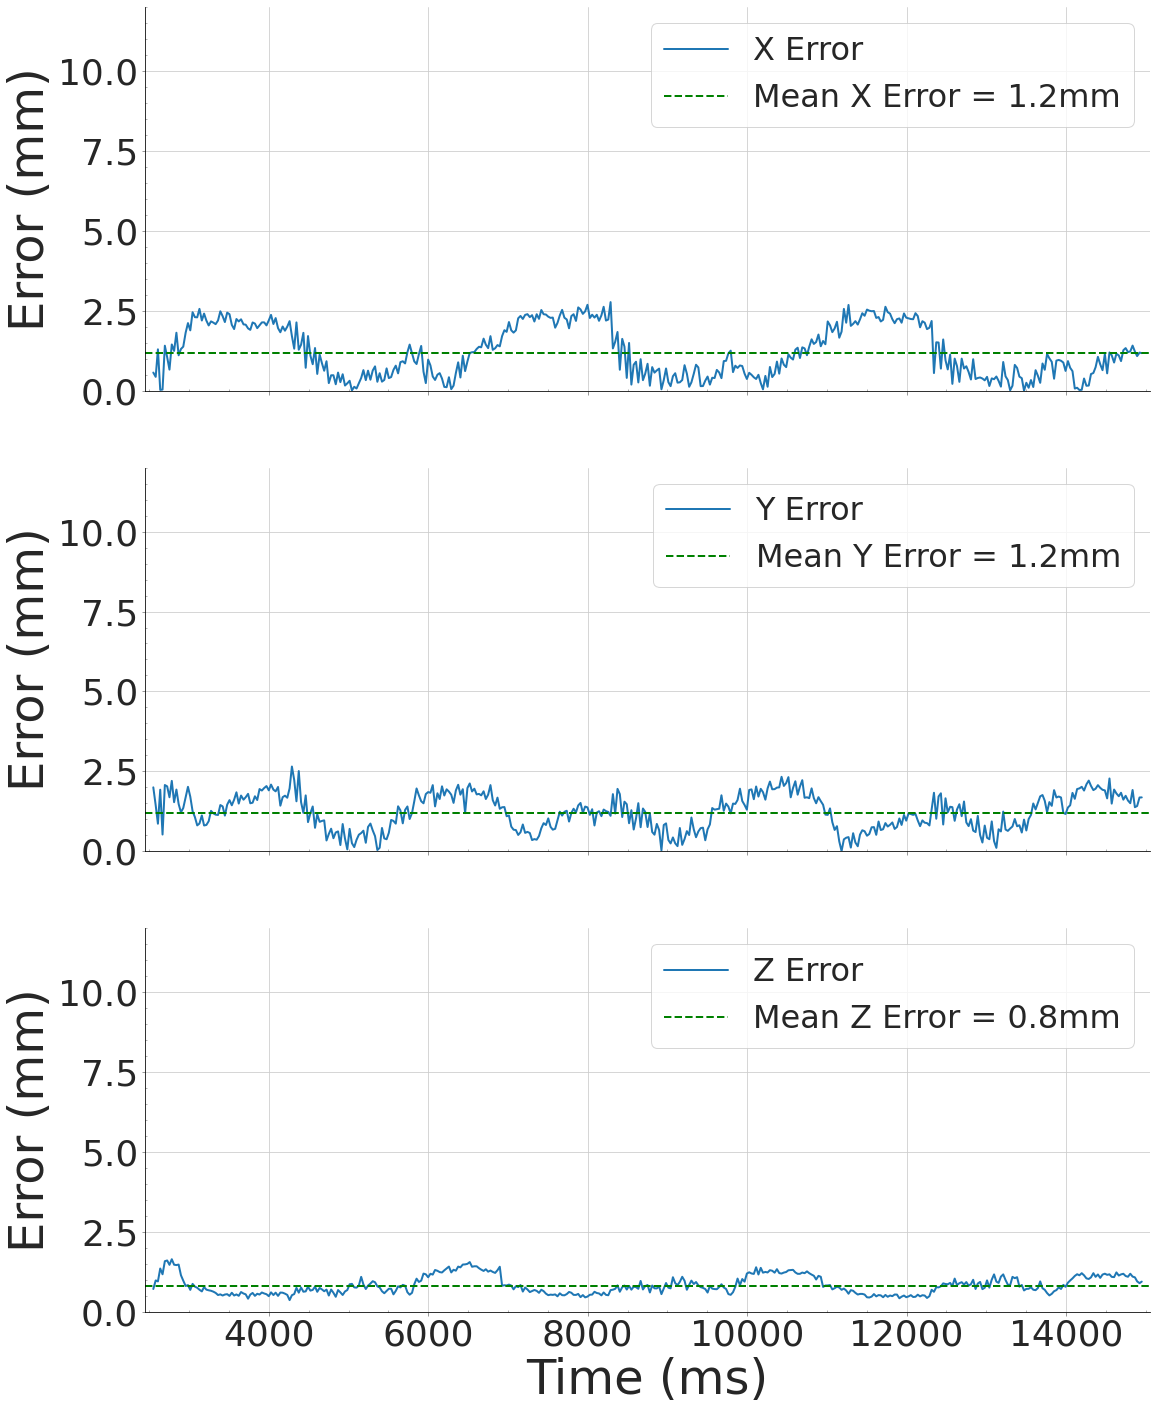

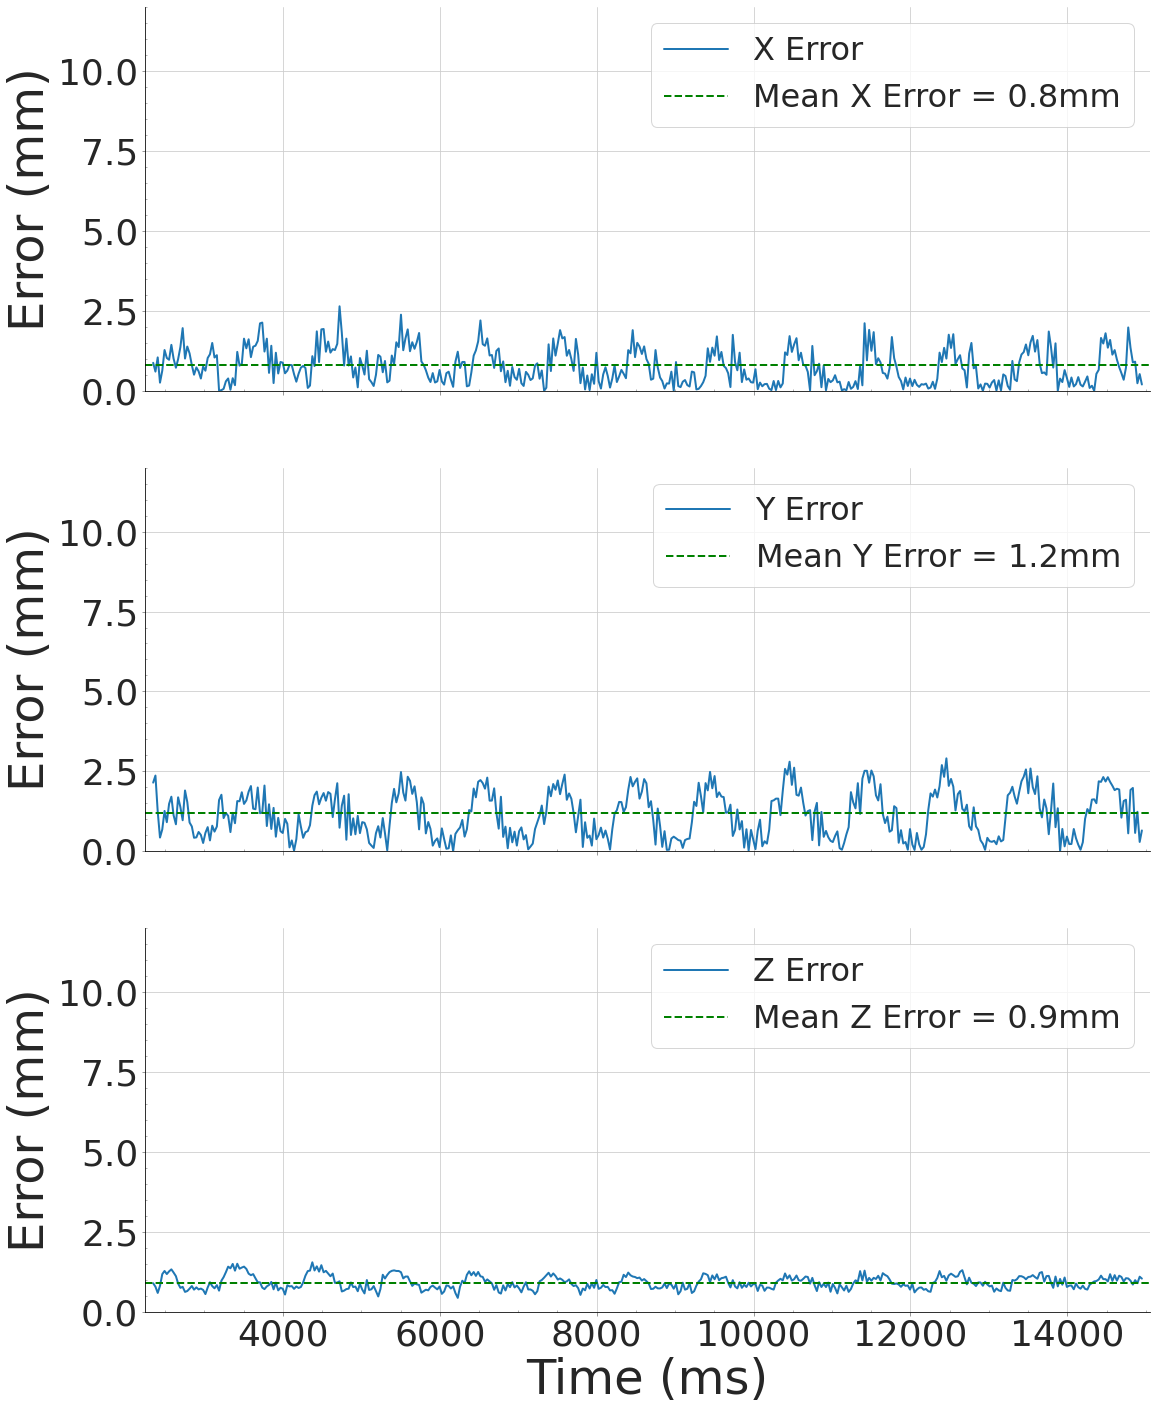

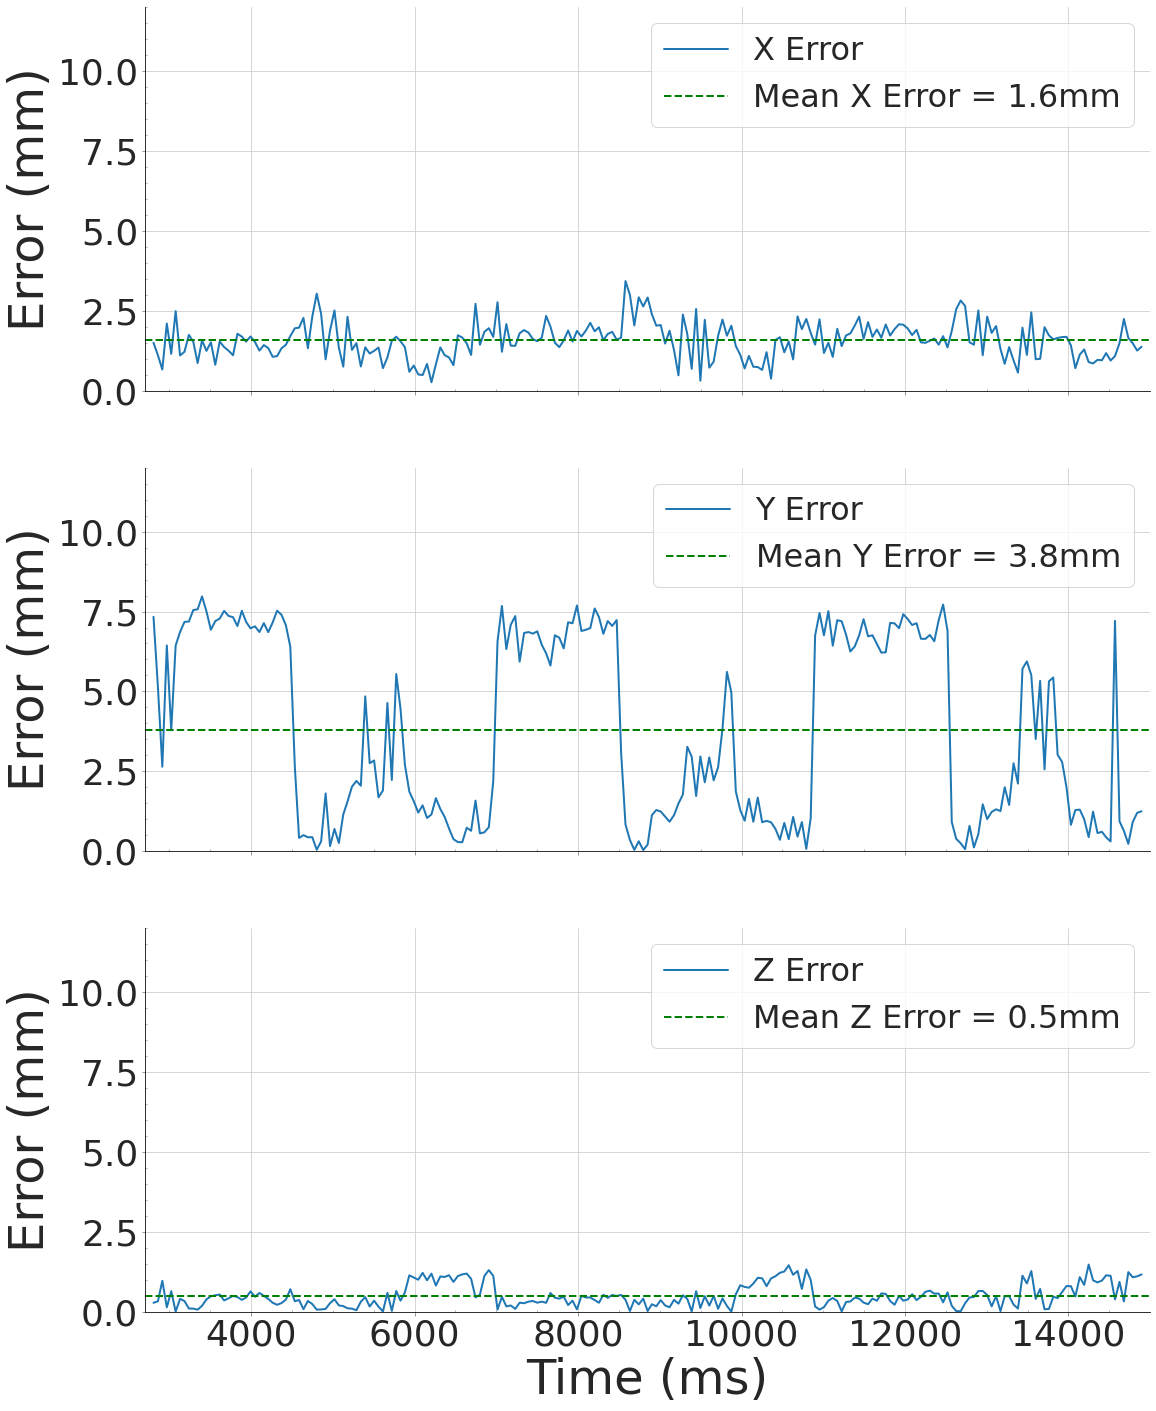

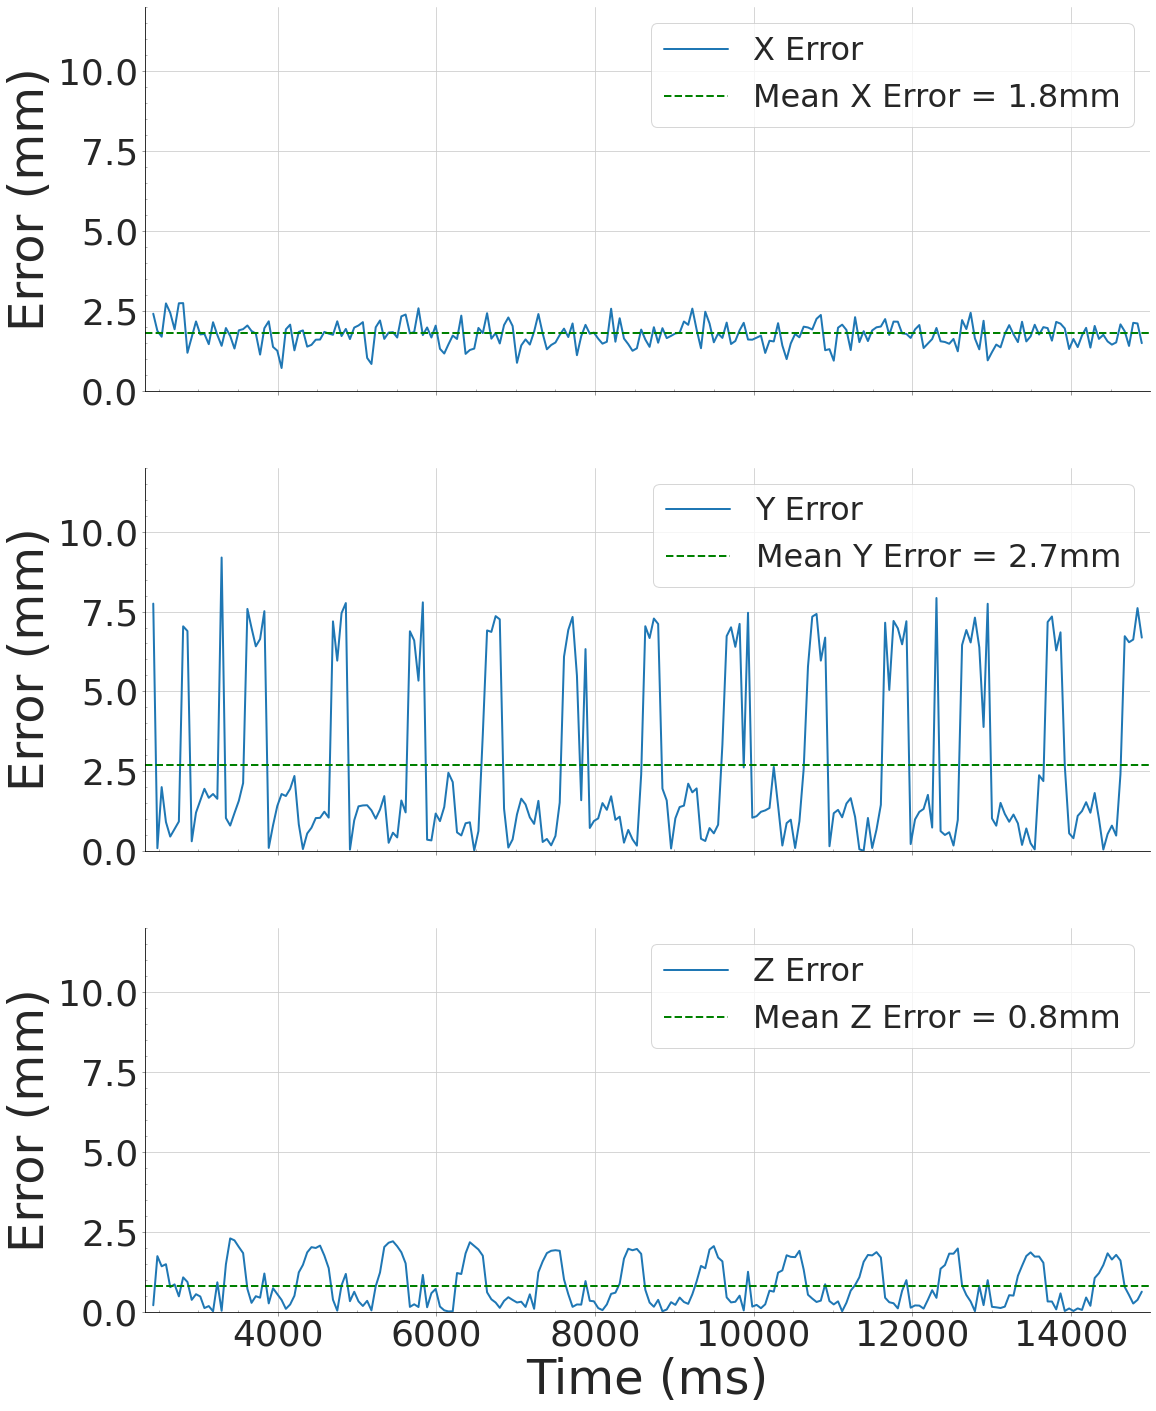

In [12]:
# # Plot error lineplots and save them to directory

# Sequence 1: Hadamard Multiplexed - JPNG
# plot_motion_error(FH512_2_jpng_7_231_resp, FH512_2_jpng_7_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_jpng_6_231_resp, FH512_2_jpng_6_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_jpng_tip_231_resp, FH512_2_jpng_tip_expected_231_resp, start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_jpng_7_231_card, FH512_2_jpng_7_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_jpng_6_231_card, FH512_2_jpng_6_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_jpng_tip_231_card, FH512_2_jpng_tip_expected_231_card, start_idx[0][1][sequences[0]], comparison_plot_paths[0])

# plot_motion_error(FH512_2_jpng_7_299_resp, FH512_2_jpng_7_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_jpng_6_299_resp, FH512_2_jpng_6_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
plot_motion_error(FH512_2_jpng_tip_299_resp, FH512_2_jpng_tip_expected_299_resp, start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_jpng_7_299_card, FH512_2_jpng_7_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_jpng_6_299_card, FH512_2_jpng_6_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
plot_motion_error(FH512_2_jpng_tip_299_card, FH512_2_jpng_tip_expected_299_card, start_idx[1][1][sequences[0]], comparison_plot_paths[1])

# plot_motion_error(FH512_2_jpng_7_306_resp, FH512_2_jpng_7_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_jpng_6_306_resp, FH512_2_jpng_6_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_jpng_tip_306_resp, FH512_2_jpng_tip_expected_306_resp, start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_jpng_7_306_card, FH512_2_jpng_7_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_jpng_6_306_card, FH512_2_jpng_6_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_jpng_tip_306_card, FH512_2_jpng_tip_expected_306_card, start_idx[2][1][sequences[0]], comparison_plot_paths[2])

# # Sequence 1: Hadamard Multiplexed - CAP
# plot_motion_error(FH512_2_cap_7_231_resp, FH512_2_cap_7_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_cap_6_231_resp, FH512_2_cap_6_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_cap_tip_231_resp, FH512_2_cap_tip_expected_231_resp, start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_cap_7_231_card, FH512_2_cap_7_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_cap_6_231_card, FH512_2_cap_6_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_cap_tip_231_card, FH512_2_cap_tip_expected_231_card, start_idx[0][1][sequences[0]], comparison_plot_paths[0])

# plot_motion_error(FH512_2_cap_7_299_resp, FH512_2_cap_7_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_cap_6_299_resp, FH512_2_cap_6_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_cap_tip_299_resp, FH512_2_cap_tip_expected_299_resp, start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_cap_7_299_card, FH512_2_cap_7_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_cap_6_299_card, FH512_2_cap_6_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_cap_tip_299_card, FH512_2_cap_tip_expected_299_card, start_idx[1][1][sequences[0]], comparison_plot_paths[1])

# plot_motion_error(FH512_2_cap_7_306_resp, FH512_2_cap_7_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_cap_6_306_resp, FH512_2_cap_6_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_cap_tip_306_resp, FH512_2_cap_tip_expected_306_resp, start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_cap_7_306_card, FH512_2_cap_7_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_cap_6_306_card, FH512_2_cap_6_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_cap_tip_306_card, FH512_2_cap_tip_expected_306_card, start_idx[2][1][sequences[0]], comparison_plot_paths[2])

# Sequence 2: Conventional - JPNG
# plot_motion_error(SRI_2_jpng_7_231_resp, SRI_2_jpng_7_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_jpng_6_231_resp, SRI_2_jpng_6_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_jpng_tip_231_resp, SRI_2_jpng_tip_expected_231_resp, start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_jpng_7_231_card, SRI_2_jpng_7_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_jpng_6_231_card, SRI_2_jpng_6_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_jpng_tip_231_card, SRI_2_jpng_tip_expected_231_card, start_idx[0][1][sequences[1]], comparison_plot_paths[0])

# plot_motion_error(SRI_2_jpng_7_299_resp, SRI_2_jpng_7_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_jpng_6_299_resp, SRI_2_jpng_6_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
plot_motion_error(SRI_2_jpng_tip_299_resp, SRI_2_jpng_tip_expected_299_resp, start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_jpng_7_299_card, SRI_2_jpng_7_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_jpng_6_299_card, SRI_2_jpng_6_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
plot_motion_error(SRI_2_jpng_tip_299_card, SRI_2_jpng_tip_expected_299_card, start_idx[1][1][sequences[1]], comparison_plot_paths[1])

# plot_motion_error(SRI_2_jpng_7_306_resp, SRI_2_jpng_7_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_jpng_6_306_resp, SRI_2_jpng_6_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_jpng_tip_306_resp, SRI_2_jpng_tip_expected_306_resp, start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_jpng_7_306_card, SRI_2_jpng_7_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_jpng_6_306_card, SRI_2_jpng_6_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_jpng_tip_306_card, SRI_2_jpng_tip_expected_306_card, start_idx[2][1][sequences[1]], comparison_plot_paths[2])

# # Sequence 2: Conventional - CAP
# plot_motion_error(SRI_2_cap_7_231_resp, SRI_2_cap_7_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_cap_6_231_resp, SRI_2_cap_6_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_cap_tip_231_resp, SRI_2_cap_tip_expected_231_resp, start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_cap_7_231_card, SRI_2_cap_7_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_cap_6_231_card, SRI_2_cap_6_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_cap_tip_231_card, SRI_2_cap_tip_expected_231_card, start_idx[0][1][sequences[1]], comparison_plot_paths[0])

# plot_motion_error(SRI_2_cap_7_299_resp, SRI_2_cap_7_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_cap_6_299_resp, SRI_2_cap_6_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_cap_tip_299_resp, SRI_2_cap_tip_expected_299_resp, start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_cap_7_299_card, SRI_2_cap_7_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_cap_6_299_card, SRI_2_cap_6_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_cap_tip_299_card, SRI_2_cap_tip_expected_299_card, start_idx[1][1][sequences[1]], comparison_plot_paths[1])

# plot_motion_error(SRI_2_cap_7_306_resp, SRI_2_cap_7_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_cap_6_306_resp, SRI_2_cap_6_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_cap_tip_306_resp, SRI_2_cap_tip_expected_306_resp, start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_cap_7_306_card, SRI_2_cap_7_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_cap_6_306_card, SRI_2_cap_6_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_cap_tip_306_card, SRI_2_cap_tip_expected_306_card, start_idx[2][1][sequences[1]], comparison_plot_paths[2])

Generate Error Boxplots

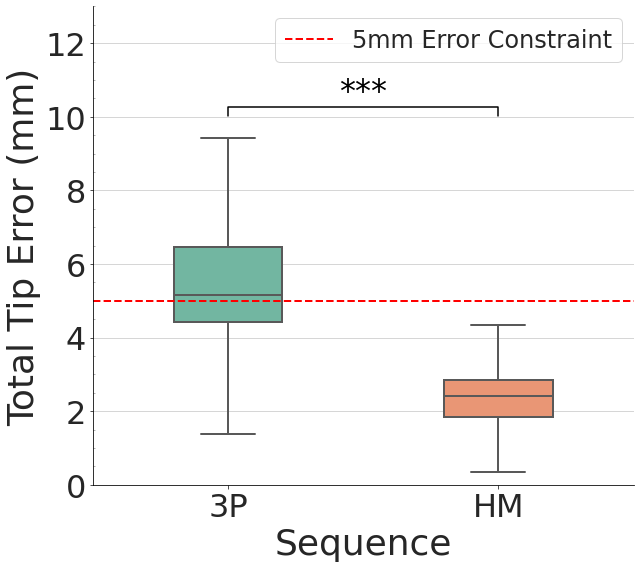

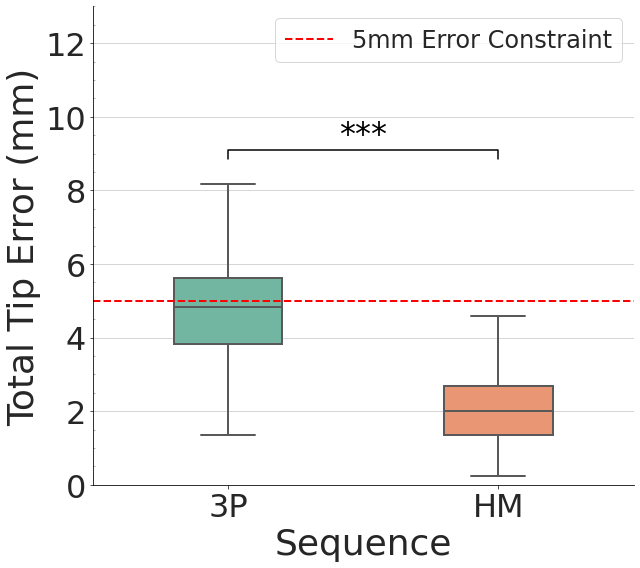

In [13]:
# Merge data for error boxplots, plot them, and save them to directory

plot_df_resp = merge_plot_dfs([SRI_2_jpng_plot_df_231_resp, SRI_2_jpng_plot_df_299_resp, SRI_2_jpng_plot_df_306_resp, FH512_2_jpng_plot_df_231_resp, FH512_2_jpng_plot_df_299_resp, FH512_2_jpng_plot_df_306_resp])
plot_df_card = merge_plot_dfs([SRI_2_jpng_plot_df_231_card, SRI_2_jpng_plot_df_299_card, SRI_2_jpng_plot_df_306_card, FH512_2_jpng_plot_df_231_card, FH512_2_jpng_plot_df_299_card, FH512_2_jpng_plot_df_306_card])

plot_error_box_plot(plot_df_resp, box_plot_path)
plot_error_box_plot(plot_df_card, box_plot_path)